In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import os
import ipywidgets as widgets
from IPython.display import display
import datetime

___
#### Data binnenhalen
___

In [2]:
locs = {'waiting_folder' : '../data/waiting times'}

waiting_times = list()
for attraction in tqdm(os.listdir(locs['waiting_folder'])):
    filename = os.path.join(locs['waiting_folder'], attraction)
    df = pd.read_csv(filename)
    if df.empty:
        continue
    df.insert(0, 'attraction', attraction.split('.')[0])
    waiting_times.append(df)

df_wait_raw = pd.concat(waiting_times, ignore_index=True)

100%|██████████| 52/52 [00:07<00:00,  6.68it/s]


In [3]:
df_wait = df_wait_raw.copy()
# Cleaning the actual waiting times
# Removing outliers from actuals
df_wait = df_wait[((df_wait.SACTMIN >= -1000) & (df_wait.SACTMIN < 360)) | (df_wait.SACTMIN.isnull())]
# Removing outliers from posted (attraction closed at -999)
df_wait = df_wait[(df_wait.SPOSTMIN >= -998.99) | (df_wait.SPOSTMIN.isnull())]

df_wait['date'] = pd.to_datetime(df_wait.date, format = '%m/%d/%Y')
df_wait['datetime'] = pd.to_datetime(df_wait.datetime, format = '%Y-%m-%d %H:%M:%S')

print(f"Removed {len(df_wait_raw) - len(df_wait)} rows")

# You could split the dataset into two seperate dataframes (plusjes & minnetjes :-))
df_wait_act = df_wait[~df_wait.SACTMIN.isnull()].drop('SPOSTMIN', axis = 1)
df_wait_post = df_wait[~df_wait.SPOSTMIN.isnull()].drop('SACTMIN', axis = 1)

attractions = df_wait.attraction.unique()

# Extract "minutes from df_wait" from the datetime column
df_wait_post['minute'] = df_wait_post['datetime'].dt.hour * 60 + df_wait_post['datetime'].dt.minute

df_wait_post['attraction'].unique()

Removed 1295640 rows


array(['alien_saucers', 'astro_orbiter', 'barnstormer', 'big_thunder_mtn',
       'buzz_lightyear', 'carousel_of_progress', 'country_bears',
       'dinosaur', 'dumbo', 'enchanted_tiki_rm', 'expedition_everest',
       'flight_of_passage', 'hall_of_presidents', 'haunted_mansion',
       'it_s_a_small_world', 'jungle_cruise', 'kilimanjaro_safaris',
       'laugh_floor', 'liberty_sq_riverboat', 'mad_tea_party',
       'magic_carpets', 'navi_river', 'peoplemover', 'peter_pan_s_flight',
       'philharmagic', 'pirates_of_caribbean', 'pirate_s_adventure',
       'princess_hall__cinderella_elena', 'princess_hall__rapunzel_tiana',
       'regal_carrousel', 'rock_n_rollercoaster', 'slinky_dog', 'soarin',
       'sorcerers_of_the_mk', 'spaceship_earth', 'space_mountain',
       'splash_mountain', 'swiss_family_tree', 'tom_land_speedway',
       'tom_sawyer_island', 'town_sq_mickey', 'toy_story_mania',
       'under_the_sea', 'winnie_the_pooh'], dtype=object)

In [4]:
df_int_time_p = pd.read_csv("../data/clean/posted_interpolated.csv")
display(df_int_time_p.head())

,attraction,date,minute,SPOSTMIN
0,astro_orbiter,2015-01-01,0,0.0
1,astro_orbiter,2015-01-01,30,0.0
2,astro_orbiter,2015-01-01,60,0.0
3,astro_orbiter,2015-01-01,90,0.0
4,astro_orbiter,2015-01-01,120,0.0


In [5]:
df_wt_pred = pd.read_csv("../data/clean/waiting_times_with_prediction.csv", index_col=0)
display(df_wt_pred.head())

,attraction,date,minute,SPOSTMIN,SACTMIN,predicted_actual_time
0,astro_orbiter,2015-01-01,0,0.0,NaN,0.0
1,astro_orbiter,2015-01-01,30,0.0,NaN,0.0
2,astro_orbiter,2015-01-01,60,0.0,NaN,0.0
3,astro_orbiter,2015-01-01,90,0.0,NaN,0.0
4,astro_orbiter,2015-01-01,120,0.0,NaN,0.0


In [6]:
df_entities_extra_raw = pd.read_csv(('../data/overview data/entities_extra.csv'))
display(df_entities_extra_raw.head())

,name,fastpass_booth,created_at,updated_at,short_name,open_emh_morning,open_emh_evening,single_rider,time_zone,seasonal,...,masthead_circle_y,latitude,longitude,open_early,themeparks_id,has_virtual_queue,relative_open_base,virtual_queue_only,fastpass_average_minutes_saved,fastpass_average_gone_at
0,Astro Orbiter,False,2009-07-13T19:14:03.000-04:00,2021-11-15T12:59:25.000-05:00,Astro Orbiter,True,True,False,Eastern Time (US & Canada),False,...,31,28.418493,-81.578989,False,d9d12438-d999-4482-894b-8955fdb20ccf,False,0,False,0,0
1,The Barnstormer,False,2009-07-13T19:14:05.000-04:00,2023-01-15T22:03:41.000-05:00,Barnstormer,True,True,False,Eastern Time (US & Canada),False,...,157,28.420766,-81.578391,False,924a3b2c-6b4b-49e5-99d3-e9dc3f2e8a48,False,0,False,3,2000-01-01T21:00:00.000Z
2,Bibbidi Bobbidi Boutique,False,2019-11-27T06:45:19.000-05:00,2020-08-18T12:14:30.000-04:00,Bibbidi Bobbidi Boutique,False,False,False,Eastern Time (US & Canada),False,...,0,28.419479,-81.581235,False,0,False,0,False,0,0
3,Big Thunder Mountain Railroad,False,2009-07-13T16:14:03.000-07:00,2023-03-21T10:41:21.000-07:00,Big Thunder Mtn,False,True,False,Eastern Time (US & Canada),False,...,194,28.419964,-81.584642,False,de3309ca-97d5-4211-bffe-739fed47e92f,False,0,False,19,2000-01-01T18:00:00.000Z
4,Buzz Lightyear's Space Ranger Spin,False,2009-07-13T16:14:03.000-07:00,2023-03-21T09:15:14.000-07:00,Buzz Lightyear,True,True,False,Eastern Time (US & Canada),False,...,80,28.418287,-81.579409,False,72c7343a-f7fb-4f66-95df-c91016de7338,False,0,False,23,2000-01-01T21:00:00.000Z


In [7]:
df_metadata_raw = pd.read_csv(('../data/overview data/metadata.csv'))
display(df_metadata_raw.head())

,DATE,WDW_TICKET_SEASON,DAYOFWEEK,DAYOFYEAR,WEEKOFYEAR,MONTHOFYEAR,YEAR,SEASON,HOLIDAYPX,HOLIDAYM,...,HSFIREWKS,AKPRDDAY,AKPRDDT1,AKPRDDT2,AKPRDDN,AKFIREN,AKSHWNGT,AKSHWNT1,AKSHWNT2,AKSHWNN
0,01/01/2015,NaN,5,0,0,1,2015,CHRISTMAS PEAK,0,5,...,1,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
1,01/02/2015,NaN,6,1,0,1,2015,CHRISTMAS,2,5,...,1,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
2,01/03/2015,NaN,7,2,0,1,2015,CHRISTMAS,3,0,...,1,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
3,01/04/2015,NaN,1,3,1,1,2015,CHRISTMAS,4,0,...,1,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
4,01/05/2015,NaN,2,4,1,1,2015,CHRISTMAS,5,0,...,1,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN


___
#### Datacleaning
- dropping columns
- changing types
- making smaller dataframes (categorically)
- merging
___

In [8]:
# merge_name komt overeen met de naam uit de waiting_time data
df_entities_extra_all = df_entities_extra_raw.copy()

df_entities_extra_all['merge_name'] = df_entities_extra_all['short_name'].copy().str.lower().str.replace(r"[\s':/]", "_", regex=True)
display(df_entities_extra_all.head())

,name,fastpass_booth,created_at,updated_at,short_name,open_emh_morning,open_emh_evening,single_rider,time_zone,seasonal,...,latitude,longitude,open_early,themeparks_id,has_virtual_queue,relative_open_base,virtual_queue_only,fastpass_average_minutes_saved,fastpass_average_gone_at,merge_name
0,Astro Orbiter,False,2009-07-13T19:14:03.000-04:00,2021-11-15T12:59:25.000-05:00,Astro Orbiter,True,True,False,Eastern Time (US & Canada),False,...,28.418493,-81.578989,False,d9d12438-d999-4482-894b-8955fdb20ccf,False,0,False,0,0,astro_orbiter
1,The Barnstormer,False,2009-07-13T19:14:05.000-04:00,2023-01-15T22:03:41.000-05:00,Barnstormer,True,True,False,Eastern Time (US & Canada),False,...,28.420766,-81.578391,False,924a3b2c-6b4b-49e5-99d3-e9dc3f2e8a48,False,0,False,3,2000-01-01T21:00:00.000Z,barnstormer
2,Bibbidi Bobbidi Boutique,False,2019-11-27T06:45:19.000-05:00,2020-08-18T12:14:30.000-04:00,Bibbidi Bobbidi Boutique,False,False,False,Eastern Time (US & Canada),False,...,28.419479,-81.581235,False,0,False,0,False,0,0,bibbidi_bobbidi_boutique
3,Big Thunder Mountain Railroad,False,2009-07-13T16:14:03.000-07:00,2023-03-21T10:41:21.000-07:00,Big Thunder Mtn,False,True,False,Eastern Time (US & Canada),False,...,28.419964,-81.584642,False,de3309ca-97d5-4211-bffe-739fed47e92f,False,0,False,19,2000-01-01T18:00:00.000Z,big_thunder_mtn
4,Buzz Lightyear's Space Ranger Spin,False,2009-07-13T16:14:03.000-07:00,2023-03-21T09:15:14.000-07:00,Buzz Lightyear,True,True,False,Eastern Time (US & Canada),False,...,28.418287,-81.579409,False,72c7343a-f7fb-4f66-95df-c91016de7338,False,0,False,23,2000-01-01T21:00:00.000Z,buzz_lightyear


In [9]:
# extra entities for all the attractions we have waiting times for

attractions_with_waitingtimes = df_wait['attraction'].unique()
df_att_with_waittime = pd.DataFrame(attractions_with_waitingtimes, columns=['attraction'])

valid_attractions = set(df_att_with_waittime['attraction'])
df_entities_extra_valid = df_entities_extra_all[df_entities_extra_all['merge_name'].isin(valid_attractions)]
display(df_entities_extra_valid.head())

,name,fastpass_booth,created_at,updated_at,short_name,open_emh_morning,open_emh_evening,single_rider,time_zone,seasonal,...,latitude,longitude,open_early,themeparks_id,has_virtual_queue,relative_open_base,virtual_queue_only,fastpass_average_minutes_saved,fastpass_average_gone_at,merge_name
0,Astro Orbiter,False,2009-07-13T19:14:03.000-04:00,2021-11-15T12:59:25.000-05:00,Astro Orbiter,True,True,False,Eastern Time (US & Canada),False,...,28.418493,-81.578989,False,d9d12438-d999-4482-894b-8955fdb20ccf,False,0,False,0,0,astro_orbiter
1,The Barnstormer,False,2009-07-13T19:14:05.000-04:00,2023-01-15T22:03:41.000-05:00,Barnstormer,True,True,False,Eastern Time (US & Canada),False,...,28.420766,-81.578391,False,924a3b2c-6b4b-49e5-99d3-e9dc3f2e8a48,False,0,False,3,2000-01-01T21:00:00.000Z,barnstormer
3,Big Thunder Mountain Railroad,False,2009-07-13T16:14:03.000-07:00,2023-03-21T10:41:21.000-07:00,Big Thunder Mtn,False,True,False,Eastern Time (US & Canada),False,...,28.419964,-81.584642,False,de3309ca-97d5-4211-bffe-739fed47e92f,False,0,False,19,2000-01-01T18:00:00.000Z,big_thunder_mtn
4,Buzz Lightyear's Space Ranger Spin,False,2009-07-13T16:14:03.000-07:00,2023-03-21T09:15:14.000-07:00,Buzz Lightyear,True,True,False,Eastern Time (US & Canada),False,...,28.418287,-81.579409,False,72c7343a-f7fb-4f66-95df-c91016de7338,False,0,False,23,2000-01-01T21:00:00.000Z,buzz_lightyear
7,Country Bear Jamboree,False,2009-07-13T19:14:03.000-04:00,2021-11-15T12:10:24.000-05:00,Country Bears,False,True,False,Eastern Time (US & Canada),False,...,28.418786,-81.583722,False,0f57cecf-5502-4503-8bc3-ba84d3708ace,False,0,False,0,0,country_bears


In [10]:
# het lijkt een beetje absurd op deze manier maar ik was vaak aan het checken of de kolommen nuttig waren en een extra kolom verwijderen is gemakkelijker dan gaan zoeken welke kolom ik eigenlijk wel terug wil

col_to_del = ['fastpass_booth','created_at','updated_at', 'short_name','single_rider','time_zone','seasonal','scheduled_code','extra_cost','what_it_is','special_needs','frightening','physical_considerations',
              'handheld_captioning','video_captioning','reflective_captioning','assistive_listening','audio_description','wheelchair_transfer_code','no_service_animals','sign_language',
              'service_animal_check','ultimate_task','park_entrance','close_at_dusk','match_name','fastpass_only','allow_showtimes_after_close','disconnected_fastpass_booth','operator_id',
              'showtime_proxy_id','ignore_scrapes','operational_notes','open_early','themeparks_id','has_virtual_queue','relative_open_base','virtual_queue_only','opened_on_known','opened_on_uncertain',
              'extinct_on_uncertain','sort_name','walking_time_proxy_id','extinct_on','wet','arrive_before_fp','arrive_before',
              'fastpass_average_gone_at','relative_open_to_sunset','relative_close_to_sunset','closing_round_code','relative_close','crowd_calendar_version','ultimate_code','relative_open',
              'hide_app']

df_entities_extra_filtered = df_entities_extra_valid.drop(col_to_del, axis= 1)
display(df_entities_extra_filtered.head())

,name,open_emh_morning,open_emh_evening,open_very_merry,open_not_so_scary,category_code,duration,scope_and_scale_code,when_to_go,average_wait_per_hundred,...,allow_time_restriction,flexible_duration,operator_type,climate_controlled,masthead_circle_x,masthead_circle_y,latitude,longitude,fastpass_average_minutes_saved,merge_name
0,Astro Orbiter,True,True,True,True,ride,1.5,minor_attraction,Before 11 a.m. or during the last hour before ...,13.5,...,False,False,Attraction,False,536,31,28.418493,-81.578989,0,astro_orbiter
1,The Barnstormer,True,True,True,True,ride,2.0,minor_attraction,"Before 10:30 a.m., during parades, or in the e...",7.0,...,False,False,Attraction,False,630,157,28.420766,-81.578391,3,barnstormer
3,Big Thunder Mountain Railroad,False,True,True,True,ride,7.0,headliner,"Before 10 a.m., in the hour before closing.",2.5,...,True,False,Attraction,False,1466,194,28.419964,-81.584642,19,big_thunder_mtn
4,Buzz Lightyear's Space Ranger Spin,True,True,True,True,ride,4.5,minor_attraction,First or last hour the park is open.,3.0,...,False,False,Attraction,True,479,80,28.418287,-81.579409,23,buzz_lightyear
7,Country Bear Jamboree,False,True,False,False,continuous_show,10.0,major_attraction,"Before 11:30 a.m., before a parade, or during ...",0.0,...,False,False,Attraction,True,860,130,28.418786,-81.583722,0,country_bears


In [11]:
df_metadata_all = df_metadata_raw.copy()
col_to_del = ['WDW_TICKET_SEASON','WDWeventN','WDWRaceN','WDWevent','WDWrace','inSession_Enrollment', 'inSession_wdw', 'inSession_dlr', 'inSession_sqrt_WDW','inSession_sqrt_DLR', 'inSession_California', 'inSession_DC', 'inSession_Central_FL',
        'inSession_Drive1_FL', 'inSession_Drive2_FL', 'inSession_Drive_CA', 'inSession_Florida','inSession_Mardi_Gras', 'inSession_Midwest', 'inSession_NY_NJ', 'inSession_NY_NJ_PA',
        'inSession_New_England', 'inSession_New_Jersey', 'inSession_Nothwest', 'INSESSION_PLANES','inSession_SoCal', 'inSession_Southwest','MKeventN','MKevent','EPeventN','EPevent','HSeventN','HSevent',
        'AKeventN','AKevent','HOLIDAYJ', 'WDWTICKETSEASON'
    ]

df_metadata = df_metadata_all.drop(col_to_del, axis= 1)
display(df_metadata.head())

,DATE,DAYOFWEEK,DAYOFYEAR,WEEKOFYEAR,MONTHOFYEAR,YEAR,SEASON,HOLIDAYPX,HOLIDAYM,HOLIDAYN,...,HSFIREWKS,AKPRDDAY,AKPRDDT1,AKPRDDT2,AKPRDDN,AKFIREN,AKSHWNGT,AKSHWNT1,AKSHWNT2,AKSHWNN
0,01/01/2015,5,0,0,1,2015,CHRISTMAS PEAK,0,5,nyd,...,1,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
1,01/02/2015,6,1,0,1,2015,CHRISTMAS,2,5,NaN,...,1,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
2,01/03/2015,7,2,0,1,2015,CHRISTMAS,3,0,NaN,...,1,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
3,01/04/2015,1,3,1,1,2015,CHRISTMAS,4,0,NaN,...,1,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
4,01/05/2015,2,4,1,1,2015,CHRISTMAS,5,0,NaN,...,1,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN


In [12]:
df_metadata['DATE'] = pd.to_datetime(df_metadata['DATE'], format='%m/%d/%Y')
df_int_time_p['date'] = pd.to_datetime(df_int_time_p['date'])
df_entities_extra_filtered['opened_on'] = pd.to_datetime(df_entities_extra_filtered['opened_on'])

___


In [13]:
df_main_variables_meta = df_metadata[['DATE','DAYOFWEEK','DAYOFYEAR','WEEKOFYEAR','MONTHOFYEAR','YEAR','SEASON','HOLIDAYPX','HOLIDAYM','HOLIDAYN','HOLIDAY', 'WDWSEASON', 'inSession']].copy()
display(df_main_variables_meta.head())

,DATE,DAYOFWEEK,DAYOFYEAR,WEEKOFYEAR,MONTHOFYEAR,YEAR,SEASON,HOLIDAYPX,HOLIDAYM,HOLIDAYN,HOLIDAY,WDWSEASON,inSession
0,2015-01-01,5,0,0,1,2015,CHRISTMAS PEAK,0,5,nyd,1,CHRISTMAS PEAK,0%
1,2015-01-02,6,1,0,1,2015,CHRISTMAS,2,5,NaN,0,CHRISTMAS,0%
2,2015-01-03,7,2,0,1,2015,CHRISTMAS,3,0,NaN,0,CHRISTMAS,0%
3,2015-01-04,1,3,1,1,2015,CHRISTMAS,4,0,NaN,0,CHRISTMAS,67%
4,2015-01-05,2,4,1,1,2015,CHRISTMAS,5,0,NaN,0,CHRISTMAS,67%


In [14]:
df_weather_variables_meta = df_metadata[['DATE', 'DAYOFWEEK', 'DAYOFYEAR', 'WEEKOFYEAR', 'MONTHOFYEAR', 'YEAR', 'WDWMAXTEMP', 'WDWMINTEMP', 'WDWMEANTEMP', 'WEATHER_WDWHIGH', 'WEATHER_WDWLOW', 'WEATHER_WDWPRECIP']].copy()
display(df_weather_variables_meta.head())

,DATE,DAYOFWEEK,DAYOFYEAR,WEEKOFYEAR,MONTHOFYEAR,YEAR,WDWMAXTEMP,WDWMINTEMP,WDWMEANTEMP,WEATHER_WDWHIGH,WEATHER_WDWLOW,WEATHER_WDWPRECIP
0,2015-01-01,5,0,0,1,2015,73.02,59.81,66.41,70.3,50.2,0.12
1,2015-01-02,6,1,0,1,2015,78.00,60.72,69.36,70.3,50.0,0.12
2,2015-01-03,7,2,0,1,2015,83.12,67.31,75.22,70.3,49.9,0.07
3,2015-01-04,1,3,1,1,2015,83.93,67.97,75.95,70.3,49.8,0.12
4,2015-01-05,2,4,1,1,2015,72.30,56.89,64.60,70.3,49.6,0.12


In [15]:
df_opening_hours_variables_meta = df_metadata[['DATE','DAYOFWEEK','DAYOFYEAR','WEEKOFYEAR','MONTHOFYEAR','YEAR', 
                                               'MKOPEN', 'MKCLOSE', 'MKHOURS', 'MKEMHOPEN', 'MKEMHCLOSE', 'MKOPENYEST', 'MKCLOSEYEST', 'MKHOURSYEST', 'MKOPENTOM', 'MKCLOSETOM', 'MKHOURSTOM', 
                                               'EPOPEN', 'EPCLOSE', 'EPHOURS', 'EPEMHOPEN', 'EPEMHCLOSE', 'EPOPENYEST', 'EPCLOSEYEST', 'EPHOURSYEST', 'EPOPENTOM', 'EPCLOSETOM', 'EPHOURSTOM', 
                                               'HSOPEN', 'HSCLOSE', 'HSHOURS', 'HSEMHOPEN', 'HSEMHCLOSE', 'HSOPENYEST', 'HSCLOSEYEST', 'HSHOURSYEST', 'HSOPENTOM', 'HSCLOSETOM', 'HSHOURSTOM', 
                                               'AKOPEN', 'AKCLOSE', 'AKHOURS', 'AKEMHOPEN', 'AKEMHCLOSE', 'AKOPENYEST', 'AKCLOSEYEST', 'AKHOURSYEST', 'AKOPENTOM', 'AKCLOSETOM', 'AKHOURSTOM']].copy()
display(df_opening_hours_variables_meta.head())

,DATE,DAYOFWEEK,DAYOFYEAR,WEEKOFYEAR,MONTHOFYEAR,YEAR,MKOPEN,MKCLOSE,MKHOURS,MKEMHOPEN,...,AKCLOSE,AKHOURS,AKEMHOPEN,AKEMHCLOSE,AKOPENYEST,AKCLOSEYEST,AKHOURSYEST,AKOPENTOM,AKCLOSETOM,AKHOURSTOM
0,2015-01-01,5,0,0,1,2015,08:00,25:00:00,17.0,07:00,...,19:00,11.0,08:00,19:00,08:00,22:00,14.0,08:00,20:00,12.0
1,2015-01-02,6,1,0,1,2015,08:00,25:00:00,17.0,08:00,...,20:00,12.0,08:00,20:00,08:00,19:00,11.0,08:00,19:00,11.0
2,2015-01-03,7,2,0,1,2015,09:00,25:00:00,16.0,09:00,...,19:00,11.0,08:00,19:00,08:00,20:00,12.0,09:00,20:00,11.0
3,2015-01-04,1,3,1,1,2015,09:00,24:00:00,15.0,09:00,...,20:00,11.0,08:00,20:00,08:00,19:00,11.0,09:00,17:00,8.0
4,2015-01-05,2,4,1,1,2015,09:00,23:00,14.0,09:00,...,17:00,8.0,09:00,17:00,09:00,20:00,11.0,09:00,17:00,8.0


In [16]:
df_extra_variables_meta = df_metadata[['DATE','DAYOFWEEK','DAYOFYEAR','WEEKOFYEAR','MONTHOFYEAR','YEAR', 
                                       'MKPRDDAY', 'MKPRDDT1', 'MKPRDDT2', 'MKPRDDN', 'MKPRDNGT', 'MKPRDNT1', 'MKPRDNT2', 
                                       'MKPRDNN', 'MKFIREWK', 'MKFIRET1', 'MKFIRET2', 'MKFIREN', 'EPFIREWK', 'EPFIRET1', 
                                       'EPFIRET2', 'EPFIREN', 'HSPRDDAY', 'HSPRDDT1', 'HSPRDDN', 'HSFIREWK', 'HSFIRET1', 
                                       'HSFIRET2', 'HSFIREN', 'HSSHWNGT', 'HSSHWNT1', 'HSSHWNT2', 'HSSHWNN', 'HSFIREWKS',
                                       'AKPRDDAY', 'AKPRDDT1', 'AKPRDDT2', 'AKPRDDN', 'AKFIREN', 'AKSHWNGT', 'AKSHWNT1', 'AKSHWNT2', 'AKSHWNN']].copy()
display(df_extra_variables_meta.head())

,DATE,DAYOFWEEK,DAYOFYEAR,WEEKOFYEAR,MONTHOFYEAR,YEAR,MKPRDDAY,MKPRDDT1,MKPRDDT2,MKPRDDN,...,HSFIREWKS,AKPRDDAY,AKPRDDT1,AKPRDDT2,AKPRDDN,AKFIREN,AKSHWNGT,AKSHWNT1,AKSHWNT2,AKSHWNN
0,2015-01-01,5,0,0,1,2015,2,12:00,15:30,Disney Festival of Fantasy Parade,...,1,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
1,2015-01-02,6,1,0,1,2015,2,12:00,15:30,Disney Festival of Fantasy Parade,...,1,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
2,2015-01-03,7,2,0,1,2015,2,12:00,15:30,Disney Festival of Fantasy Parade,...,1,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
3,2015-01-04,1,3,1,1,2015,1,15:00,NaN,Disney Festival of Fantasy Parade,...,1,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
4,2015-01-05,2,4,1,1,2015,1,15:00,NaN,Disney Festival of Fantasy Parade,...,1,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN


In [17]:
def inches_to_cm(inches):
  return inches * 2.54

def fahrenheit_to_celsius(fahrenheit):
  return (fahrenheit - 32) * 5/9

df_entities_extra_filtered['height_restriction'] = df_entities_extra_filtered['height_restriction'].apply(inches_to_cm)

columns_to_convert = ['WDWMAXTEMP', 'WDWMINTEMP', 'WDWMEANTEMP', 'WEATHER_WDWHIGH', 'WEATHER_WDWLOW']
for col in columns_to_convert:
    df_weather_variables_meta[col] = df_weather_variables_meta[col].apply(fahrenheit_to_celsius)

In [18]:
df_itp_entities = pd.merge(df_int_time_p, df_entities_extra_filtered, left_on='attraction', right_on='merge_name')
display(df_itp_entities.head())

,attraction,date,minute,SPOSTMIN,name,open_emh_morning,open_emh_evening,open_very_merry,open_not_so_scary,category_code,...,allow_time_restriction,flexible_duration,operator_type,climate_controlled,masthead_circle_x,masthead_circle_y,latitude,longitude,fastpass_average_minutes_saved,merge_name
0,astro_orbiter,2015-01-01,0,0.0,Astro Orbiter,True,True,True,True,ride,...,False,False,Attraction,False,536,31,28.418493,-81.578989,0,astro_orbiter
1,astro_orbiter,2015-01-01,30,0.0,Astro Orbiter,True,True,True,True,ride,...,False,False,Attraction,False,536,31,28.418493,-81.578989,0,astro_orbiter
2,astro_orbiter,2015-01-01,60,0.0,Astro Orbiter,True,True,True,True,ride,...,False,False,Attraction,False,536,31,28.418493,-81.578989,0,astro_orbiter
3,astro_orbiter,2015-01-01,90,0.0,Astro Orbiter,True,True,True,True,ride,...,False,False,Attraction,False,536,31,28.418493,-81.578989,0,astro_orbiter
4,astro_orbiter,2015-01-01,120,0.0,Astro Orbiter,True,True,True,True,ride,...,False,False,Attraction,False,536,31,28.418493,-81.578989,0,astro_orbiter


In [19]:
# List of integer columns to preserve
int_cols_to_preserve = ['DAYOFWEEK', 'DAYOFYEAR', 'WEEKOFYEAR', 'MONTHOFYEAR', 'YEAR']

# Function to merge and process DataFrames
def merge_and_process(df_to_merge, df_meta):
    # Convert integer columns to Int64 before merge
    for col in int_cols_to_preserve:
        if col in df_meta.columns:
            df_meta[col] = df_meta[col].astype('Int64')

    # Perform the merge
    merged_df = pd.merge(df_to_merge, df_meta, left_on='date', right_on='DATE', how='inner')

    # Drop the 'DATE' column
    merged_df = merged_df.drop('DATE', axis=1)

    # Display the head of the merged DataFrame
    display(merged_df.head(3))

    return merged_df

# Merge and process df_int_time_p with metadata DataFrames
df_int_time_p_main = merge_and_process(df_int_time_p, df_main_variables_meta)
df_int_time_p_weather = merge_and_process(df_int_time_p, df_weather_variables_meta)
df_int_time_p_opening = merge_and_process(df_int_time_p, df_opening_hours_variables_meta)
df_int_time_p_extra = merge_and_process(df_int_time_p, df_extra_variables_meta)

,attraction,date,minute,SPOSTMIN,DAYOFWEEK,DAYOFYEAR,WEEKOFYEAR,MONTHOFYEAR,YEAR,SEASON,HOLIDAYPX,HOLIDAYM,HOLIDAYN,HOLIDAY,WDWSEASON,inSession
0,astro_orbiter,2015-01-01,0,0.0,5,0,0,1,2015,CHRISTMAS PEAK,0,5,nyd,1,CHRISTMAS PEAK,0%
1,astro_orbiter,2015-01-01,30,0.0,5,0,0,1,2015,CHRISTMAS PEAK,0,5,nyd,1,CHRISTMAS PEAK,0%
2,astro_orbiter,2015-01-01,60,0.0,5,0,0,1,2015,CHRISTMAS PEAK,0,5,nyd,1,CHRISTMAS PEAK,0%


,attraction,date,minute,SPOSTMIN,DAYOFWEEK,DAYOFYEAR,WEEKOFYEAR,MONTHOFYEAR,YEAR,WDWMAXTEMP,WDWMINTEMP,WDWMEANTEMP,WEATHER_WDWHIGH,WEATHER_WDWLOW,WEATHER_WDWPRECIP
0,astro_orbiter,2015-01-01,0,0.0,5,0,0,1,2015,22.788889,15.45,19.116667,21.277778,10.111111,0.12
1,astro_orbiter,2015-01-01,30,0.0,5,0,0,1,2015,22.788889,15.45,19.116667,21.277778,10.111111,0.12
2,astro_orbiter,2015-01-01,60,0.0,5,0,0,1,2015,22.788889,15.45,19.116667,21.277778,10.111111,0.12


,attraction,date,minute,SPOSTMIN,DAYOFWEEK,DAYOFYEAR,WEEKOFYEAR,MONTHOFYEAR,YEAR,MKOPEN,...,AKCLOSE,AKHOURS,AKEMHOPEN,AKEMHCLOSE,AKOPENYEST,AKCLOSEYEST,AKHOURSYEST,AKOPENTOM,AKCLOSETOM,AKHOURSTOM
0,astro_orbiter,2015-01-01,0,0.0,5,0,0,1,2015,08:00,...,19:00,11.0,08:00,19:00,08:00,22:00,14.0,08:00,20:00,12.0
1,astro_orbiter,2015-01-01,30,0.0,5,0,0,1,2015,08:00,...,19:00,11.0,08:00,19:00,08:00,22:00,14.0,08:00,20:00,12.0
2,astro_orbiter,2015-01-01,60,0.0,5,0,0,1,2015,08:00,...,19:00,11.0,08:00,19:00,08:00,22:00,14.0,08:00,20:00,12.0


,attraction,date,minute,SPOSTMIN,DAYOFWEEK,DAYOFYEAR,WEEKOFYEAR,MONTHOFYEAR,YEAR,MKPRDDAY,...,HSFIREWKS,AKPRDDAY,AKPRDDT1,AKPRDDT2,AKPRDDN,AKFIREN,AKSHWNGT,AKSHWNT1,AKSHWNT2,AKSHWNN
0,astro_orbiter,2015-01-01,0,0.0,5,0,0,1,2015,2,...,1,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
1,astro_orbiter,2015-01-01,30,0.0,5,0,0,1,2015,2,...,1,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
2,astro_orbiter,2015-01-01,60,0.0,5,0,0,1,2015,2,...,1,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN


___
## park offers

In [20]:
chosen_busy_days = ['2018-05-12', '2019-02-26']
chosen_slow_days = ['2017-10-05', '2018-05-20']

In [21]:
chosen_busy_days = ['2018-05-12', '2019-02-26']
chosen_slow_days = ['2017-10-05', '2018-05-20']
chosen_days = chosen_busy_days + chosen_slow_days

time_data = df_itp_entities.copy()
time_data = time_data[['attraction', 'date', 'minute', 'SPOSTMIN', 'when_to_go', 'probable_wait_time',
                       'fastpass_average_minutes_saved', 'not_to_be_missed','scope_and_scale_code']].copy()
time_data = time_data[time_data['date'].isin(chosen_days)].copy()

def should_go(row):
    minute = row['minute']
    when_to_go = row['when_to_go']

    if pd.isna(when_to_go) or when_to_go == '0':
        return True  # Anytime is fine or no info

    when_to_go = when_to_go.lower()

    if 'anytime' in when_to_go:
        return True

    if 'first 30 minutes' in when_to_go:
        if minute <= 30:
            return True
    if 'first hour' in when_to_go:
        if minute <= 60:
            return True
    if 'last 30 minutes' in when_to_go:
        if minute >= 1410: #23:30 in minutes
            return True
    if 'last hour' in when_to_go:
        if minute >= 1380: #23:00 in minutes
            return True
    if 'before 10 a.m.' in when_to_go:
        if minute < 600:
            return True
    if 'before 10:30 a.m.' in when_to_go:
        if minute < 630:
            return True
    if 'before 11 a.m.' in when_to_go:
        if minute < 660:
            return True
    if 'before 11:30 a.m.' in when_to_go:
        if minute < 690:
            return True
    if 'before noon' in when_to_go:
        if minute < 720:
            return True
    if 'after 3:30 p.m.' in when_to_go:
        if minute >= 930:
            return True
    if 'after 5 p.m.' in when_to_go:
        if minute >= 1020:
            return True
    if 'after 7 p.m.' in when_to_go:
        if minute >= 1140:
            return True
    if 'after 8 p.m.' in when_to_go:
        if minute >= 1200:
            return True
    if '2 hours before closing' in when_to_go:
        if minute >= 1320: # 22:00
            return True
    if 'midmorning-late afternoon' in when_to_go:
        if 660 <= minute <= 1020: # 11am and 5pm
            return False
        else:
            return True

    return False # Default: don't go

time_data['go_now'] = time_data.apply(should_go, axis=1)

display(time_data.sample(5))

C:\Users\masha\AppData\Local\Temp\ipykernel_2668\2516405303.py:8: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  time_data = time_data[time_data['date'].isin(chosen_days)].copy()


,attraction,date,minute,SPOSTMIN,when_to_go,probable_wait_time,fastpass_average_minutes_saved,not_to_be_missed,scope_and_scale_code,go_now
1342334,it_s_a_small_world,2018-05-20,120,0.0,Anytime,0,9,False,major_attraction,True
1342724,pirates_of_caribbean,2018-05-20,270,0.0,Before noon or after 5 p.m.,0,16,True,headliner,True
1342133,big_thunder_mtn,2018-05-20,690,30.0,"Before 10 a.m., in the hour before closing.",0,19,True,headliner,False
1660564,peoplemover,2019-02-26,120,0.0,"Anytime, but especially during hot, crowded ti...",0,0,False,minor_attraction,True
1660632,peter_pan_s_flight,2019-02-26,510,5.0,First or last 30 minutes the park is open.,0,38,True,minor_attraction,False


In [22]:
# Create a copy of the original DataFrame to avoid overwriting
df_int_time_p_opening_chosen = df_opening_hours_variables_meta .copy()

# Convert 'date' to datetime if it's not already
df_opening_hours_variables_meta ['DATE'] = pd.to_datetime(df_opening_hours_variables_meta ['DATE'])

# Filter based on chosen_days
filtered_df_chosen = df_opening_hours_variables_meta [df_opening_hours_variables_meta ['DATE'].isin(chosen_days)].copy()

# Explicitly define the columns you want
desired_columns_chosen = ['DATE', 'MKOPEN', 'MKCLOSE', 'EPOPEN', 'EPCLOSE', 'HSOPEN', 'HSCLOSE', 'AKOPEN', 'AKCLOSE']

# Create a new DataFrame with only the desired columns
opening_hours_chosen = filtered_df_chosen[desired_columns_chosen].copy()

# Display the result
display(opening_hours_chosen)
print(opening_hours_chosen.dtypes)

C:\Users\masha\AppData\Local\Temp\ipykernel_2668\853249116.py:8: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  filtered_df_chosen = df_opening_hours_variables_meta [df_opening_hours_variables_meta ['DATE'].isin(chosen_days)].copy()


,DATE,MKOPEN,MKCLOSE,EPOPEN,EPCLOSE,HSOPEN,HSCLOSE,AKOPEN,AKCLOSE
1008,2017-10-05,09:00,19:00,09:00,21:00,09:00,20:30,09:00,20:30
1227,2018-05-12,09:00,24:00:00,09:00,21:00,09:00,21:30,09:00,21:00
1235,2018-05-20,09:00,22:00,09:00,21:00,09:00,21:30,09:00,22:00
1517,2019-02-26,09:00,21:00,09:00,21:00,09:00,20:00,09:00,20:00


DATE       datetime64[ns]
MKOPEN             object
MKCLOSE            object
EPOPEN             object
EPCLOSE            object
HSOPEN             object
HSCLOSE            object
AKOPEN             object
AKCLOSE            object
dtype: object


In [23]:
# Convert time columns to minutes
def time_to_minutes(time_str):
    if pd.isna(time_str):
        return None
    try:
        parts = time_str.split(':')
        hours = int(parts[0])
        minutes = int(parts[1])
        return hours * 60 + minutes
    except (ValueError, AttributeError):
        return None

for col in ['MKOPEN', 'MKCLOSE', 'EPOPEN', 'EPCLOSE', 'HSOPEN', 'HSCLOSE', 'AKOPEN', 'AKCLOSE']:
    opening_hours_chosen[col] = opening_hours_chosen[col].apply(time_to_minutes)

# Find earliest open and latest close
def get_earliest_open(row):
    open_times = [val for val in [row['MKOPEN'], row['EPOPEN'], row['HSOPEN'], row['AKOPEN']] if pd.notna(val)]
    if open_times:
        return min(open_times)
    else:
        return None

def get_latest_close(row):
    close_times = [val for val in [row['MKCLOSE'], row['EPCLOSE'], row['HSCLOSE'], row['AKCLOSE']] if pd.notna(val)]
    if close_times:
        return max(close_times)
    else:
        return None

opening_hours_chosen['earliest_open'] = opening_hours_chosen.apply(get_earliest_open, axis=1)
opening_hours_chosen['latest_close'] = opening_hours_chosen.apply(get_latest_close, axis=1)

# Create datetime columns for open and close
opening_hours_chosen['open_datetime'] = opening_hours_chosen.apply(
    lambda row: pd.to_datetime(row['DATE']) + datetime.timedelta(minutes=row['earliest_open']) if pd.notna(row['earliest_open']) else pd.NaT,
    axis=1
)

opening_hours_chosen['close_datetime'] = opening_hours_chosen.apply(
    lambda row: pd.to_datetime(row['DATE']) + datetime.timedelta(minutes=row['latest_close']) if pd.notna(row['latest_close']) else pd.NaT,
    axis=1
)

# Display the final result
display(opening_hours_chosen)

,DATE,MKOPEN,MKCLOSE,EPOPEN,EPCLOSE,HSOPEN,HSCLOSE,AKOPEN,AKCLOSE,earliest_open,latest_close,open_datetime,close_datetime
1008,2017-10-05,540,1140,540,1260,540,1230,540,1230,540,1260,2017-10-05 09:00:00,2017-10-05 21:00:00
1227,2018-05-12,540,1440,540,1260,540,1290,540,1260,540,1440,2018-05-12 09:00:00,2018-05-13 00:00:00
1235,2018-05-20,540,1320,540,1260,540,1290,540,1320,540,1320,2018-05-20 09:00:00,2018-05-20 22:00:00
1517,2019-02-26,540,1260,540,1260,540,1200,540,1200,540,1260,2019-02-26 09:00:00,2019-02-26 21:00:00


In [24]:
time_data = time_data.rename(columns={'date': 'DATE'})

# Merge the DataFrames on 'DATE'
merged_data = pd.merge(time_data, opening_hours_chosen, on='DATE', how='left')

# Display the merged DataFrame
display(merged_data)


,attraction,DATE,minute,SPOSTMIN,when_to_go,probable_wait_time,fastpass_average_minutes_saved,not_to_be_missed,scope_and_scale_code,go_now,...,EPOPEN,EPCLOSE,HSOPEN,HSCLOSE,AKOPEN,AKCLOSE,earliest_open,latest_close,open_datetime,close_datetime
0,astro_orbiter,2017-10-05,0,0.0,Before 11 a.m. or during the last hour before ...,0,0,False,minor_attraction,True,...,540,1260,540,1230,540,1230,540,1260,2017-10-05 09:00:00,2017-10-05 21:00:00
1,astro_orbiter,2017-10-05,30,0.0,Before 11 a.m. or during the last hour before ...,0,0,False,minor_attraction,True,...,540,1260,540,1230,540,1230,540,1260,2017-10-05 09:00:00,2017-10-05 21:00:00
2,astro_orbiter,2017-10-05,60,0.0,Before 11 a.m. or during the last hour before ...,0,0,False,minor_attraction,True,...,540,1260,540,1230,540,1230,540,1260,2017-10-05 09:00:00,2017-10-05 21:00:00
3,astro_orbiter,2017-10-05,90,0.0,Before 11 a.m. or during the last hour before ...,0,0,False,minor_attraction,True,...,540,1260,540,1230,540,1230,540,1260,2017-10-05 09:00:00,2017-10-05 21:00:00
4,astro_orbiter,2017-10-05,120,0.0,Before 11 a.m. or during the last hour before ...,0,0,False,minor_attraction,True,...,540,1260,540,1230,540,1230,540,1260,2017-10-05 09:00:00,2017-10-05 21:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4340,winnie_the_pooh,2019-02-26,1500,15.0,"Before 10 a.m., in the 2 hours before closing.",0,15,False,minor_attraction,True,...,540,1260,540,1200,540,1200,540,1260,2019-02-26 09:00:00,2019-02-26 21:00:00
4341,winnie_the_pooh,2019-02-26,1530,15.0,"Before 10 a.m., in the 2 hours before closing.",0,15,False,minor_attraction,True,...,540,1260,540,1200,540,1200,540,1260,2019-02-26 09:00:00,2019-02-26 21:00:00
4342,winnie_the_pooh,2019-02-26,1560,15.0,"Before 10 a.m., in the 2 hours before closing.",0,15,False,minor_attraction,True,...,540,1260,540,1200,540,1200,540,1260,2019-02-26 09:00:00,2019-02-26 21:00:00
4343,winnie_the_pooh,2019-02-26,1590,15.0,"Before 10 a.m., in the 2 hours before closing.",0,15,False,minor_attraction,True,...,540,1260,540,1200,540,1200,540,1260,2019-02-26 09:00:00,2019-02-26 21:00:00


In [25]:
def should_go_adjusted(row):
    minute = row['minute']
    when_to_go = row['when_to_go']
    latest_close = row['latest_close']
    earliest_open = row['earliest_open']

    if pd.isna(when_to_go) or when_to_go == '0':
        if pd.notna(earliest_open) and pd.notna(latest_close):
            if earliest_open <= minute < latest_close:
                return True
            else:
                return False
        else:
            return True # if no open/close times, just go

    if pd.notna(earliest_open) and minute < earliest_open:
        return False  # Park not open yet

    if pd.notna(latest_close) and minute >= latest_close:
        return False # park closed

    when_to_go = when_to_go.lower()

    if 'anytime' in when_to_go:
        return True

    if 'first 30 minutes' in when_to_go:
        if pd.notna(earliest_open) and minute >= earliest_open and minute <= earliest_open + 30:
            return True
    if 'first hour' in when_to_go:
        if pd.notna(earliest_open) and minute >= earliest_open and minute <= earliest_open + 60:
            return True
    if 'last 30 minutes' in when_to_go:
        if pd.notna(latest_close) and minute >= (latest_close - 30):
            return True
    if 'last hour' in when_to_go:
        if pd.notna(latest_close) and minute >= (latest_close - 60):
            return True
    if 'before 10 a.m.' in when_to_go:
        if minute < 600:
            return True
    if 'before 10:30 a.m.' in when_to_go:
        if minute < 630:
            return True
    if 'before 11 a.m.' in when_to_go:
        if minute < 660:
            return True
    if 'before 11:30 a.m.' in when_to_go:
        if minute < 690:
            return True
    if 'before noon' in when_to_go:
        if minute < 720:
            return True
    if 'after 3:30 p.m.' in when_to_go:
        if minute >= 930:
            return True
    if 'after 5 p.m.' in when_to_go:
        if minute >= 1020:
            return True
    if 'after 7 p.m.' in when_to_go:
        if minute >= 1140:
            return True
    if 'after 8 p.m.' in when_to_go:
        if minute >= 1200:
            return True
    if '2 hours before closing' in when_to_go:
        if pd.notna(latest_close) and minute >= (latest_close - 120):
            return True
    if 'midmorning-late afternoon' in when_to_go:
        if 660 <= minute <= 1020:
            return False
        else:
            return True

    return False  # Default: don't go

merged_data['go_now_adjusted'] = merged_data.apply(should_go_adjusted, axis=1)


display(merged_data.sample(5))

,attraction,DATE,minute,SPOSTMIN,when_to_go,probable_wait_time,fastpass_average_minutes_saved,not_to_be_missed,scope_and_scale_code,go_now,...,EPCLOSE,HSOPEN,HSCLOSE,AKOPEN,AKCLOSE,earliest_open,latest_close,open_datetime,close_datetime,go_now_adjusted
3036,tom_land_speedway,2018-05-20,330,0.0,Before 10 a.m. or during last 2 hours before c...,0,5,False,major_attraction,True,...,1260,540,1290,540,1320,540,1320,2018-05-20 09:00:00,2018-05-20 22:00:00,False
2670,mad_tea_party,2018-05-20,900,10.0,Before 11 a.m. or after 5 p.m.,0,11,False,minor_attraction,False,...,1260,540,1290,540,1320,540,1320,2018-05-20 09:00:00,2018-05-20 22:00:00,False
3838,magic_carpets,2019-02-26,1290,5.0,Before 10 a.m. or in the hour before park clos...,0,18,False,minor_attraction,False,...,1260,540,1200,540,1200,540,1260,2019-02-26 09:00:00,2019-02-26 21:00:00,False
4165,space_mountain,2019-02-26,1200,20.0,When the park opens.,0,22,True,super_headliner,False,...,1260,540,1200,540,1200,540,1260,2019-02-26 09:00:00,2019-02-26 21:00:00,False
1009,under_the_sea,2017-10-05,570,10.0,"Before 10:30 a.m., during the last 2 hours bef...",0,12,False,minor_attraction,True,...,1260,540,1230,540,1230,540,1260,2017-10-05 09:00:00,2017-10-05 21:00:00,True


In [26]:
park_offers = merged_data.drop(['go_now','MKOPEN','MKCLOSE',	'EPOPEN',	'EPCLOSE',	'HSOPEN',	'HSCLOSE',	'AKOPEN',	'AKCLOSE'], axis=1).copy()

display(park_offers.sample(5))

,attraction,DATE,minute,SPOSTMIN,when_to_go,probable_wait_time,fastpass_average_minutes_saved,not_to_be_missed,scope_and_scale_code,earliest_open,latest_close,open_datetime,close_datetime,go_now_adjusted
2428,haunted_mansion,2018-05-20,240,0.0,Before 11:30 a.m. or after 8 p.m.,0,19,True,major_attraction,540,1320,2018-05-20 09:00:00,2018-05-20 22:00:00,False
2201,barnstormer,2018-05-20,30,0.0,"Before 10:30 a.m., during parades, or in the e...",0,3,False,minor_attraction,540,1320,2018-05-20 09:00:00,2018-05-20 22:00:00,False
2769,peter_pan_s_flight,2018-05-20,570,55.0,First or last 30 minutes the park is open.,0,38,True,minor_attraction,540,1320,2018-05-20 09:00:00,2018-05-20 22:00:00,False
36,astro_orbiter,2017-10-05,1080,10.0,Before 11 a.m. or during the last hour before ...,0,0,False,minor_attraction,540,1260,2017-10-05 09:00:00,2017-10-05 21:00:00,False
4255,under_the_sea,2019-02-26,600,15.0,"Before 10:30 a.m., during the last 2 hours bef...",0,12,False,minor_attraction,540,1260,2019-02-26 09:00:00,2019-02-26 21:00:00,True


In [ ]:
park_offers_open = park_offers[
    (park_offers['minute'] >= park_offers['earliest_open']) & 
    (park_offers['minute'] < park_offers['latest_close'])
].copy()

display(park_offers_open)

,attraction,DATE,minute,SPOSTMIN,when_to_go,probable_wait_time,fastpass_average_minutes_saved,not_to_be_missed,scope_and_scale_code,earliest_open,latest_close,open_datetime,close_datetime,go_now_adjusted
18,astro_orbiter,2017-10-05,540,0.0,Before 11 a.m. or during the last hour before ...,0,0,False,minor_attraction,540,1260,2017-10-05 09:00:00,2017-10-05 21:00:00,True
19,astro_orbiter,2017-10-05,570,10.0,Before 11 a.m. or during the last hour before ...,0,0,False,minor_attraction,540,1260,2017-10-05 09:00:00,2017-10-05 21:00:00,True
20,astro_orbiter,2017-10-05,600,10.0,Before 11 a.m. or during the last hour before ...,0,0,False,minor_attraction,540,1260,2017-10-05 09:00:00,2017-10-05 21:00:00,True
21,astro_orbiter,2017-10-05,630,10.0,Before 11 a.m. or during the last hour before ...,0,0,False,minor_attraction,540,1260,2017-10-05 09:00:00,2017-10-05 21:00:00,True
22,astro_orbiter,2017-10-05,660,10.0,Before 11 a.m. or during the last hour before ...,0,0,False,minor_attraction,540,1260,2017-10-05 09:00:00,2017-10-05 21:00:00,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4327,winnie_the_pooh,2019-02-26,1110,30.0,"Before 10 a.m., in the 2 hours before closing.",0,15,False,minor_attraction,540,1260,2019-02-26 09:00:00,2019-02-26 21:00:00,False
4328,winnie_the_pooh,2019-02-26,1140,45.0,"Before 10 a.m., in the 2 hours before closing.",0,15,False,minor_attraction,540,1260,2019-02-26 09:00:00,2019-02-26 21:00:00,True
4329,winnie_the_pooh,2019-02-26,1170,30.0,"Before 10 a.m., in the 2 hours before closing.",0,15,False,minor_attraction,540,1260,2019-02-26 09:00:00,2019-02-26 21:00:00,True
4330,winnie_the_pooh,2019-02-26,1200,15.0,"Before 10 a.m., in the 2 hours before closing.",0,15,False,minor_attraction,540,1260,2019-02-26 09:00:00,2019-02-26 21:00:00,True


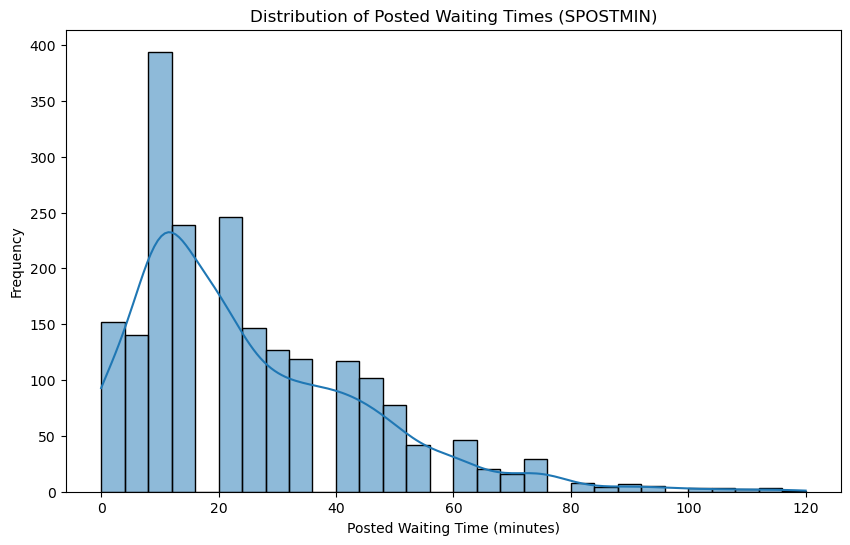

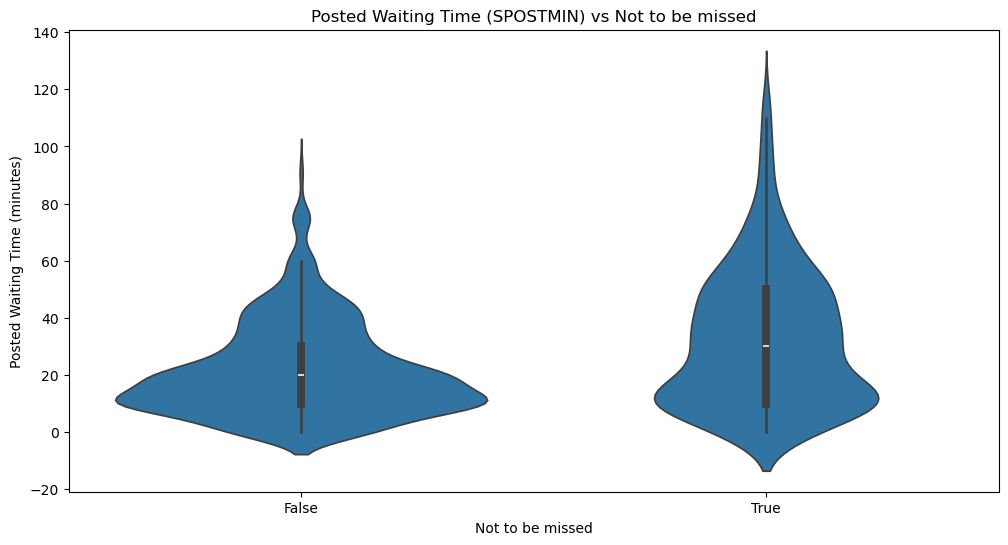

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(park_offers_open['SPOSTMIN'], bins=30, kde=True)
plt.title('Distribution of Posted Waiting Times ')
plt.xlabel('Posted Waiting Time (minutes)')
plt.ylabel('Frequency')
plt.show()


plt.figure(figsize=(12, 6))
sns.violinplot(x='not_to_be_missed', y='SPOSTMIN', data=park_offers_open)
plt.title('Posted Waiting Time (SPOSTMIN) vs Not to be missed')
plt.xlabel('Not to be missed')
plt.ylabel('Posted Waiting Time (minutes)')
plt.show()


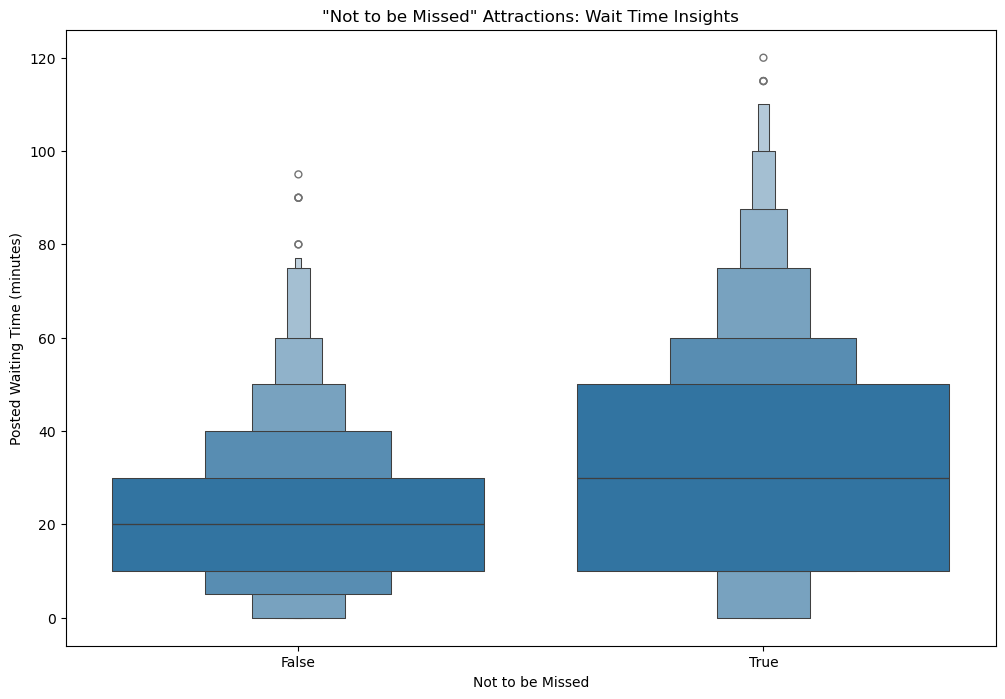

Wait Time Differences:
   not_to_be_missed      mean    max  mean_diff_pct  max_diff_times
0             False  21.57784   95.0            NaN             NaN
1              True  32.44391  120.0          50.36        1.263158


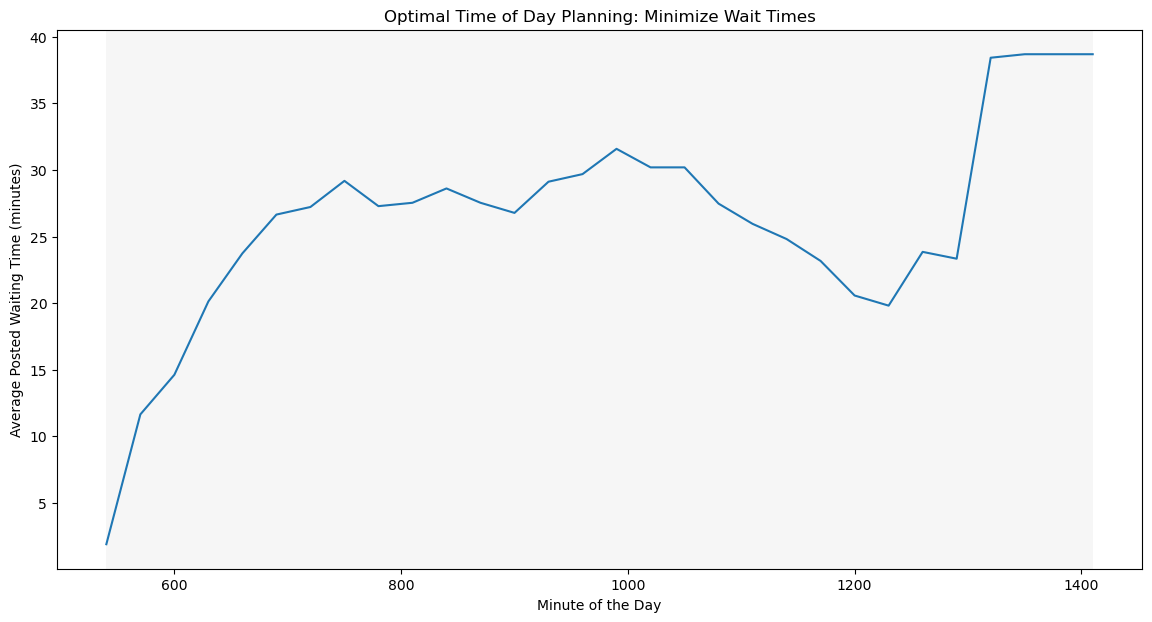

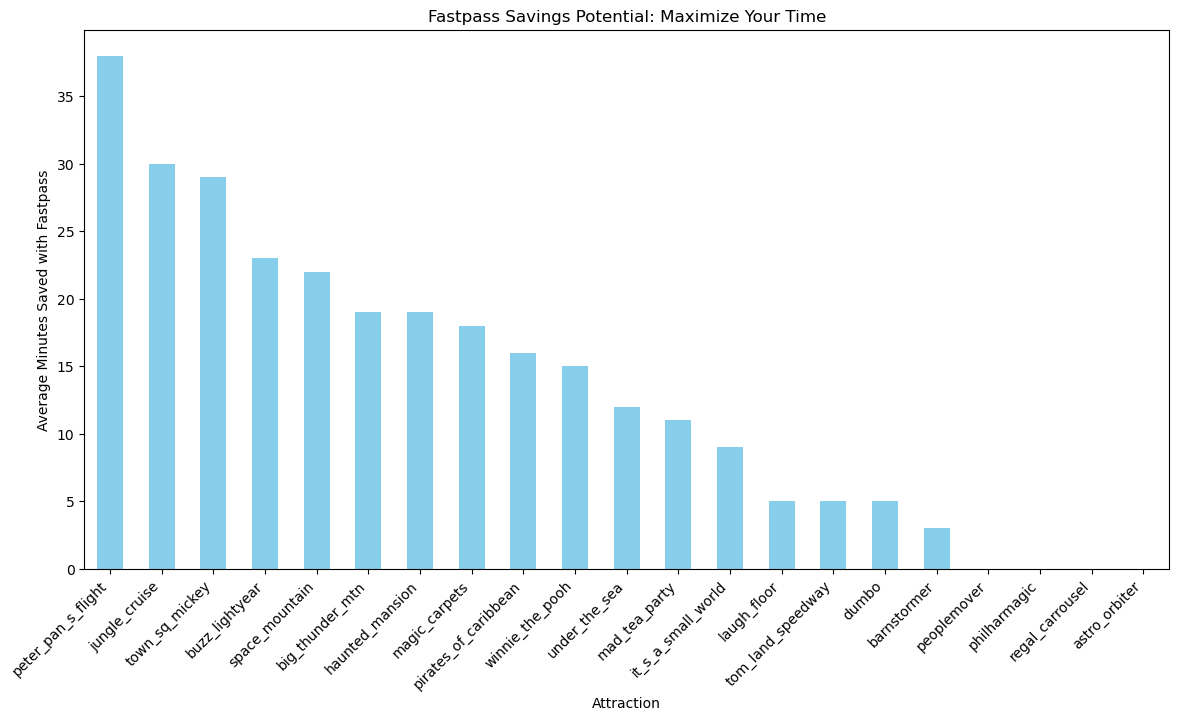

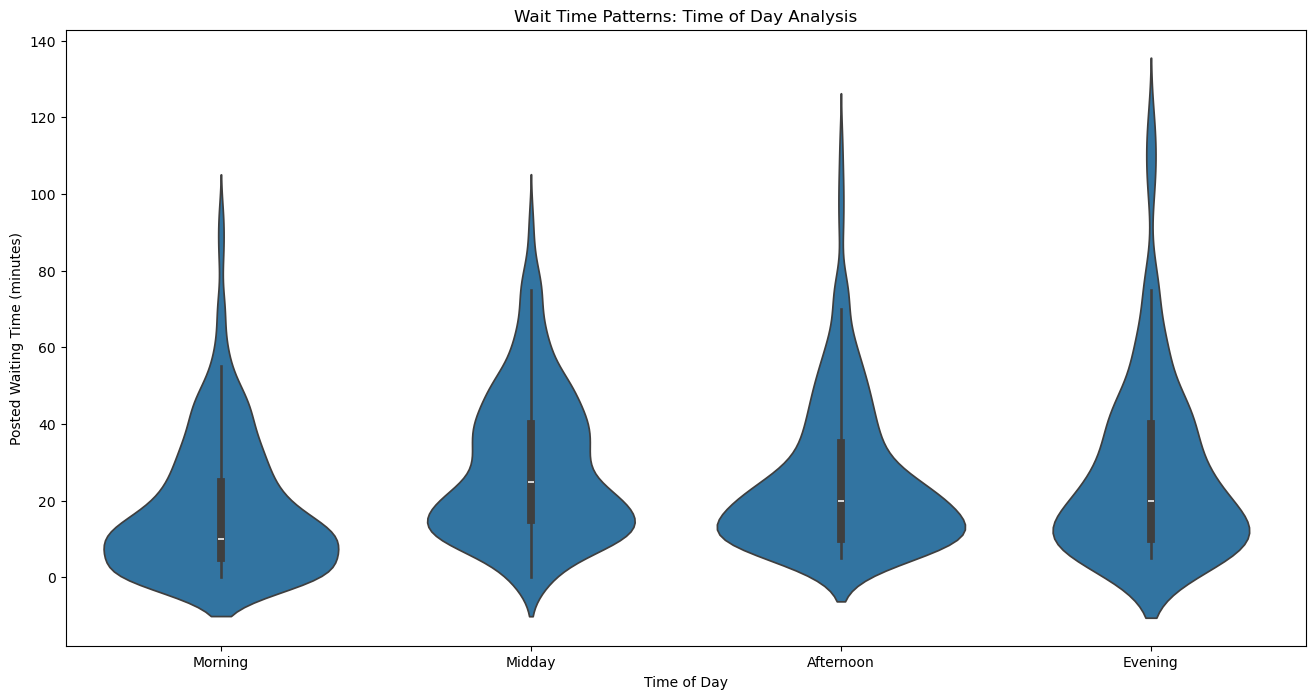

In [29]:
# 2. "Not to be Missed" vs. Wait Times (Violin/Boxen Combo)
plt.figure(figsize=(12, 8))
sns.boxenplot(x='not_to_be_missed', y='SPOSTMIN', data=park_offers_open)
plt.title('"Not to be Missed" Attractions: Wait Time Insights')
plt.xlabel('Not to be Missed')
plt.ylabel('Posted Waiting Time (minutes)')
plt.show()

not_missed_stats = park_offers_open.groupby('not_to_be_missed')['SPOSTMIN'].agg(['mean', 'max']).reset_index()

# Calculate percentage differences
not_missed_stats['mean_diff_pct'] = (not_missed_stats['mean'].pct_change() * 100).round(2)
not_missed_stats['max_diff_times'] = not_missed_stats['max'] / not_missed_stats['max'].shift(1)
# Print the percentage differences
print("Wait Time Differences:")
print(not_missed_stats)

# 3. Time of Day Optimization (Line Plot with Shaded Regions)
minute_avg = park_offers_open.groupby('minute')['SPOSTMIN'].mean().reset_index()
plt.figure(figsize=(14, 7))
sns.lineplot(x='minute', y='SPOSTMIN', data=minute_avg)
plt.title('Optimal Time of Day Planning: Minimize Wait Times')
plt.xlabel('Minute of the Day')
plt.ylabel('Average Posted Waiting Time (minutes)')
plt.axvspan(xmin=minute_avg['minute'].min(), xmax=minute_avg['minute'].max(), facecolor='lightgray', alpha=0.2) # Shaded region
plt.show()

# 4. Fastpass Savings Potential (Bar Plot)
fastpass_savings = park_offers_open.groupby('attraction')['fastpass_average_minutes_saved'].mean().sort_values(ascending=False)
plt.figure(figsize=(14, 7))
fastpass_savings.plot(kind='bar', color='skyblue')
plt.title('Fastpass Savings Potential: Maximize Your Time')
plt.xlabel('Attraction')
plt.ylabel('Average Minutes Saved with Fastpass')
plt.xticks(rotation=45, ha='right')
plt.show()

# 5. Wait Time Distribution by Time of Day (Violin Plots)
park_offers_open['time_of_day'] = pd.cut(park_offers_open['minute'], bins=[480, 720, 1020,1200, 1440], labels=['Morning', 'Midday', 'Afternoon', 'Evening'])
plt.figure(figsize=(16, 8))
sns.violinplot(x='time_of_day', y='SPOSTMIN', data=park_offers_open)
plt.title('Wait Time Patterns: Time of Day Analysis')
plt.xlabel('Time of Day')
plt.ylabel('Posted Waiting Time (minutes)')
plt.show()


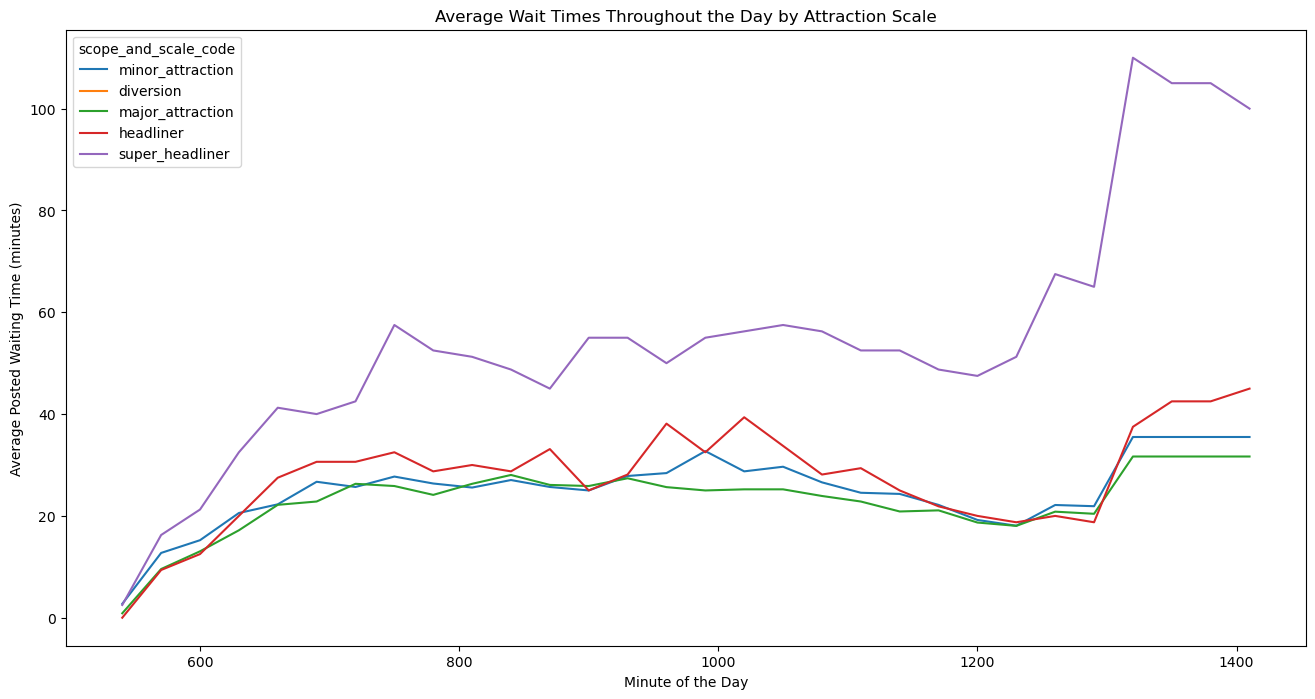

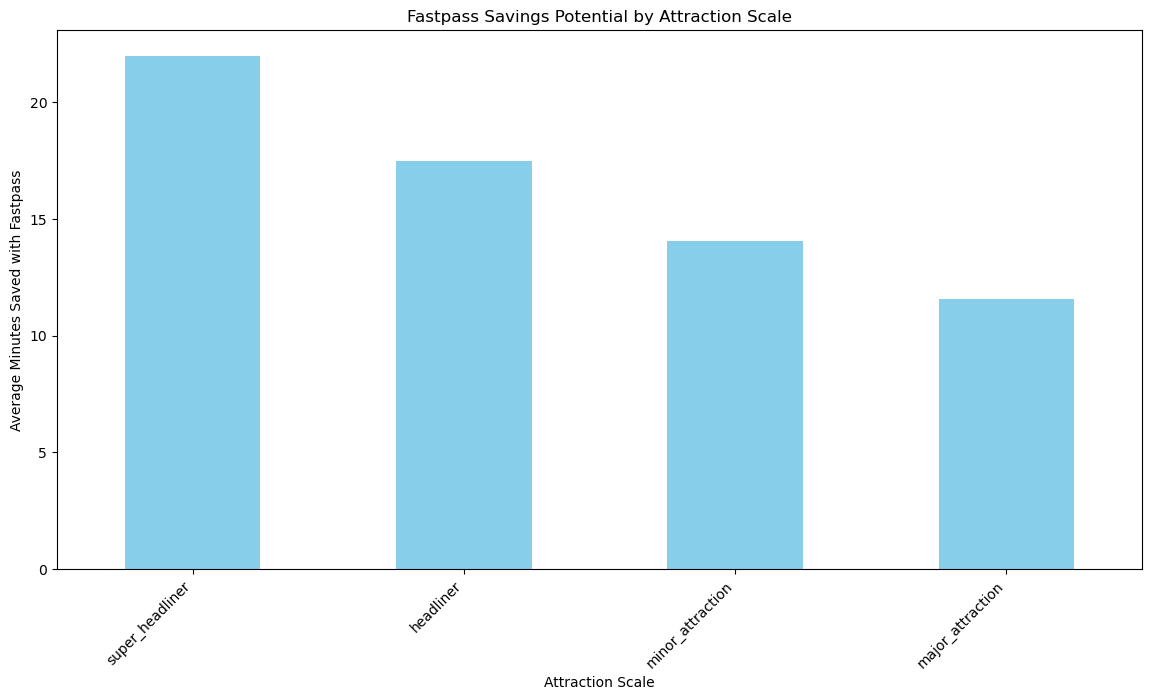

In [30]:



# 3. Time of Day Optimization by Scale (Line Plot)
scale_minute_avg = park_offers_open.groupby(['minute', 'scope_and_scale_code'])['SPOSTMIN'].mean().reset_index()
plt.figure(figsize=(16, 8))
sns.lineplot(x='minute', y='SPOSTMIN', hue='scope_and_scale_code', data=scale_minute_avg, hue_order=['minor_attraction', 'diversion', 'major_attraction', 'headliner', 'super_headliner'])
plt.title('Average Wait Times Throughout the Day by Attraction Scale')
plt.xlabel('Minute of the Day')
plt.ylabel('Average Posted Waiting Time (minutes)')
plt.show()

# 4. Fastpass Savings Potential by Scale (Bar Plot)
fastpass_scale_savings = park_offers_open.groupby('scope_and_scale_code')['fastpass_average_minutes_saved'].mean().sort_values(ascending=False)
plt.figure(figsize=(14, 7))
fastpass_scale_savings.plot(kind='bar', color='skyblue')
plt.title('Fastpass Savings Potential by Attraction Scale')
plt.xlabel('Attraction Scale')
plt.ylabel('Average Minutes Saved with Fastpass')
plt.xticks(rotation=45, ha='right')
plt.show()



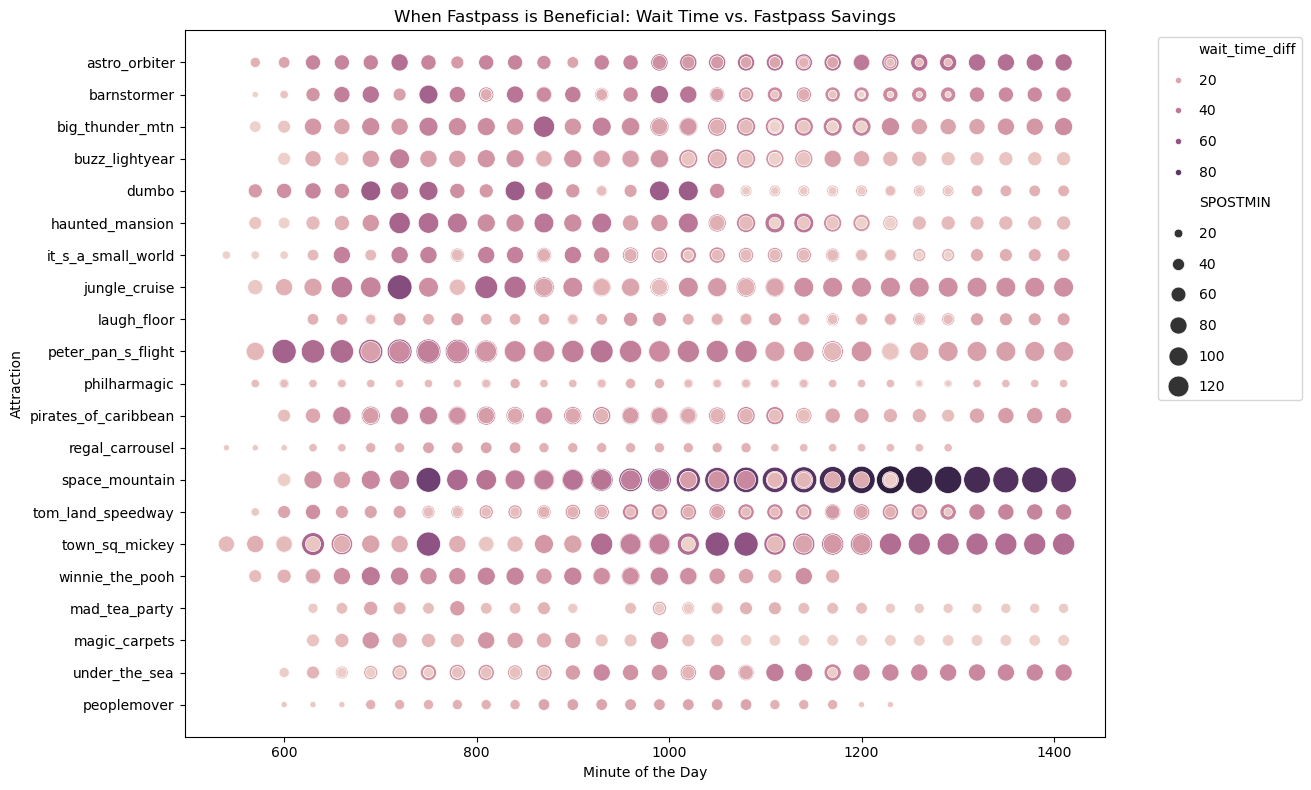

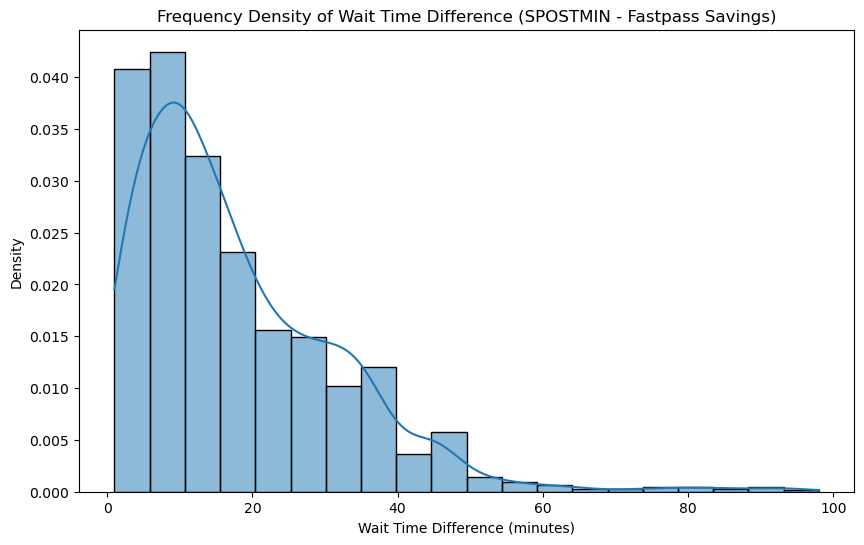

In [31]:
park_offers_open['wait_time_diff'] = park_offers_open['SPOSTMIN'] - park_offers_open['fastpass_average_minutes_saved']

# Filter for rows where wait time is greater than fastpass savings
fastpass_benefit = park_offers_open[park_offers_open['wait_time_diff'] > 0]

# Visualize the benefit of Fastpass
plt.figure(figsize=(14, 8))
sns.scatterplot(x='minute', y='attraction', hue='wait_time_diff', size='SPOSTMIN', sizes=(20, 400), data=fastpass_benefit)
plt.title('When Fastpass is Beneficial: Wait Time vs. Fastpass Savings')
plt.xlabel('Minute of the Day')
plt.ylabel('Attraction')

# Move legend outside and adjust spacing
legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', markerscale=0.75, handletextpad=0.5, labelspacing=1.2) #adjusted markerscale, handletextpad, and labelspacing
plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.show()

# Optional: Visualize the distribution of the difference
plt.figure(figsize=(10, 6))
sns.histplot(fastpass_benefit['wait_time_diff'], bins=20, kde=True, stat='density') # Change stat to 'density'
plt.title('Frequency Density of Wait Time Difference (SPOSTMIN - Fastpass Savings)')
plt.xlabel('Wait Time Difference (minutes)')
plt.ylabel('Density') # Change ylabel to 'Density'
plt.show()



In [ ]:
def should_go_adjusted(row):
    minute = row['minute']
    when_to_go = str(row['when_to_go']).lower()  
    latest_close = row['latest_close']
    earliest_open = row['earliest_open']

    if pd.isna(when_to_go) or when_to_go == '0' or when_to_go == 'nan':
        if pd.notna(earliest_open) and pd.notna(latest_close):
            return earliest_open <= minute < latest_close
        else:
            return True  


    if pd.notna(earliest_open) and minute < earliest_open:
        return False 
    if pd.notna(latest_close) and minute >= latest_close:
        return False 

    if 'anytime' in when_to_go:
        return True
    if 'first 30 minutes' in when_to_go and pd.notna(earliest_open) and minute >= earliest_open and minute <= earliest_open + 30:
        return True
    if 'first hour' in when_to_go and pd.notna(earliest_open) and minute >= earliest_open and minute <= earliest_open + 60:
        return True
    if 'last 30 minutes' in when_to_go and pd.notna(latest_close) and minute >= (latest_close - 30):
        return True
    if 'last hour' in when_to_go and pd.notna(latest_close) and minute >= (latest_close - 60):
        return True
    if '2 hours before closing' in when_to_go and pd.notna(latest_close) and minute >= (latest_close - 120):
        return True
    if 'before 10 a.m.' in when_to_go and minute < 600:
        return True
    if 'before 10:30 a.m.' in when_to_go and minute < 630:
        return True
    if 'before 11 a.m.' in when_to_go and minute < 660:
        return True
    if 'before 11:30 a.m.' in when_to_go and minute < 690:
        return True
    if 'before noon' in when_to_go and minute < 720:
        return True
    if 'after 3:30 p.m.' in when_to_go and minute >= 930:
        return True
    if 'after 5 p.m.' in when_to_go and minute >= 1020:
        return True
    if 'after 7 p.m.' in when_to_go and minute >= 1140:
        return True
    if 'after 8 p.m.' in when_to_go and minute >= 1200:
        return True
    if 'midmorning-late afternoon' in when_to_go and 660 <= minute <= 1020:
        return False
    if 'when the park opens.' in when_to_go and pd.notna(earliest_open) and minute == earliest_open:
        return True
    if 'anytime, but especially during hot, crowded times of day (11:30 a.m.-4:30 p.m.)' in when_to_go and 690 <= minute <= 1050:
        return True
    if 'anytime, but after dark is better for the effects' in when_to_go:
        if minute >= 1140: #after 7pm
            return True
        else:
            return False
    if 'before a parade' in when_to_go or 'during parades' in when_to_go:
        return False
    if 'first or last hour' in when_to_go and pd.notna(earliest_open) and minute >= earliest_open and minute <= earliest_open + 60:
        return True
    if 'first or last 30 minutes' in when_to_go and pd.notna(earliest_open) and minute >= earliest_open and minute <= earliest_open + 30:
        return True
    if 'evening just before the park closes' in when_to_go and pd.notna(latest_close) and minute >= (latest_close - 30):
        return True

    return False
# assuming park_offers_open is already defined.
park_offers_open['go_now_adjusted'] = park_offers_open.apply(should_go_adjusted, axis=1)

#print unique go_now_adjusted values
print(park_offers_open['go_now_adjusted'].unique())

space_mountain_data = park_offers_open[park_offers_open['attraction'] == 'dumbo']
display(space_mountain_data[['minute', 'when_to_go', 'go_now_adjusted']].head(30))

[ True False]


,minute,when_to_go,go_now_adjusted
238,540,Before 11 a.m. or after 7 p.m.,True
239,570,Before 11 a.m. or after 7 p.m.,True
240,600,Before 11 a.m. or after 7 p.m.,True
241,630,Before 11 a.m. or after 7 p.m.,True
242,660,Before 11 a.m. or after 7 p.m.,False
243,690,Before 11 a.m. or after 7 p.m.,False
244,720,Before 11 a.m. or after 7 p.m.,False
245,750,Before 11 a.m. or after 7 p.m.,False
246,780,Before 11 a.m. or after 7 p.m.,False
247,810,Before 11 a.m. or after 7 p.m.,False


Unique when_to_go values for space mountain: ['Before 10 a.m. or 2 hours before closing.']


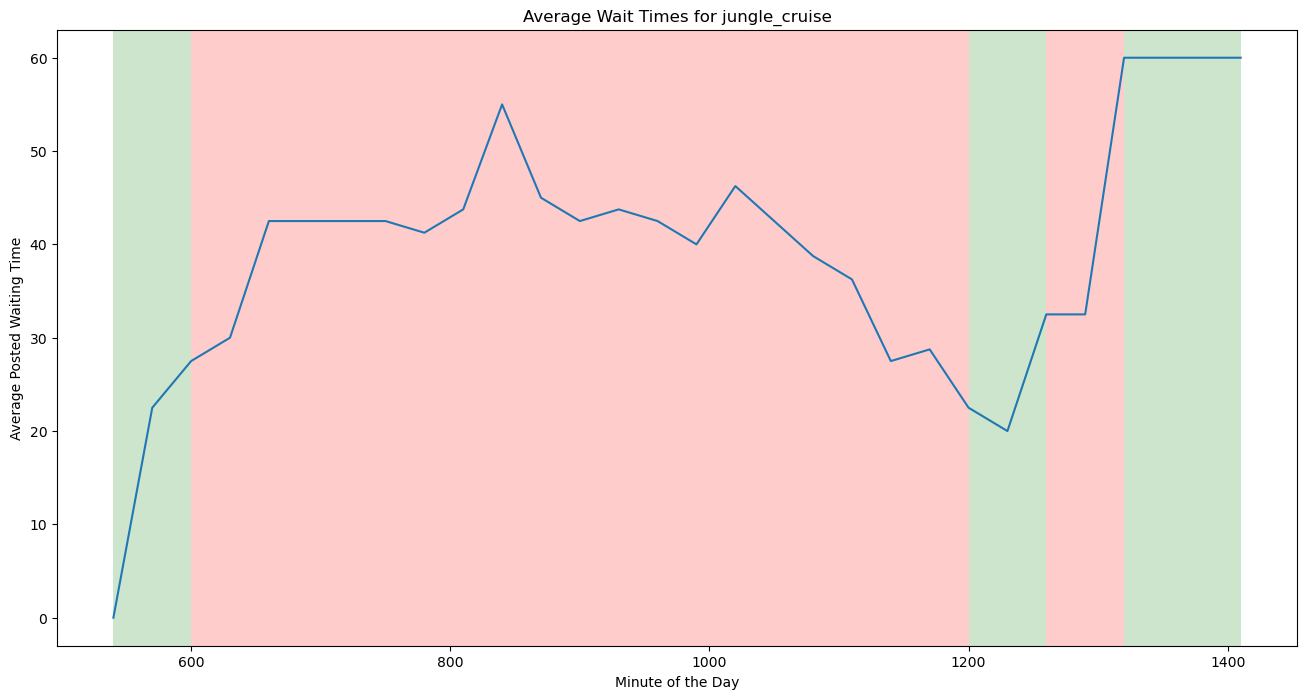

In [33]:
chosen_attraction = 'jungle_cruise'  # Choose an attraction

attraction_data = park_offers_open[park_offers_open['attraction'] == chosen_attraction].copy()

# Debug: Inspect when_to_go column
print("Unique when_to_go values for space mountain:", attraction_data['when_to_go'].unique())

# Sort by minute
attraction_data = attraction_data.sort_values(by='minute')

# Calculate average wait times by minute and get the mode of go_now_adjusted
grouped = attraction_data.groupby('minute').agg({'SPOSTMIN': 'mean', 'go_now_adjusted': lambda x: x.mode()[0] if not x.mode().empty else False})

# Sort by minute
grouped = grouped.sort_index()

# Create the line plot of average wait times
plt.figure(figsize=(16, 8))
plt.plot(grouped.index, grouped['SPOSTMIN'])

# Shade based on go_now_adjusted
for i in range(len(grouped) - 1):
    if grouped['go_now_adjusted'].iloc[i]:
        plt.axvspan(grouped.index[i], grouped.index[i + 1], facecolor='green', alpha=0.2)
    else:
        plt.axvspan(grouped.index[i], grouped.index[i + 1], facecolor='red', alpha=0.2)

plt.title(f'Average Wait Times for {chosen_attraction}')
plt.xlabel('Minute of the Day')
plt.ylabel('Average Posted Waiting Time')
plt.show()

C:\Users\masha\AppData\Local\Temp\ipykernel_2668\1503656996.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="WEEKOFYEAR", y="SPOSTMIN", data=week_avg, palette=palette)


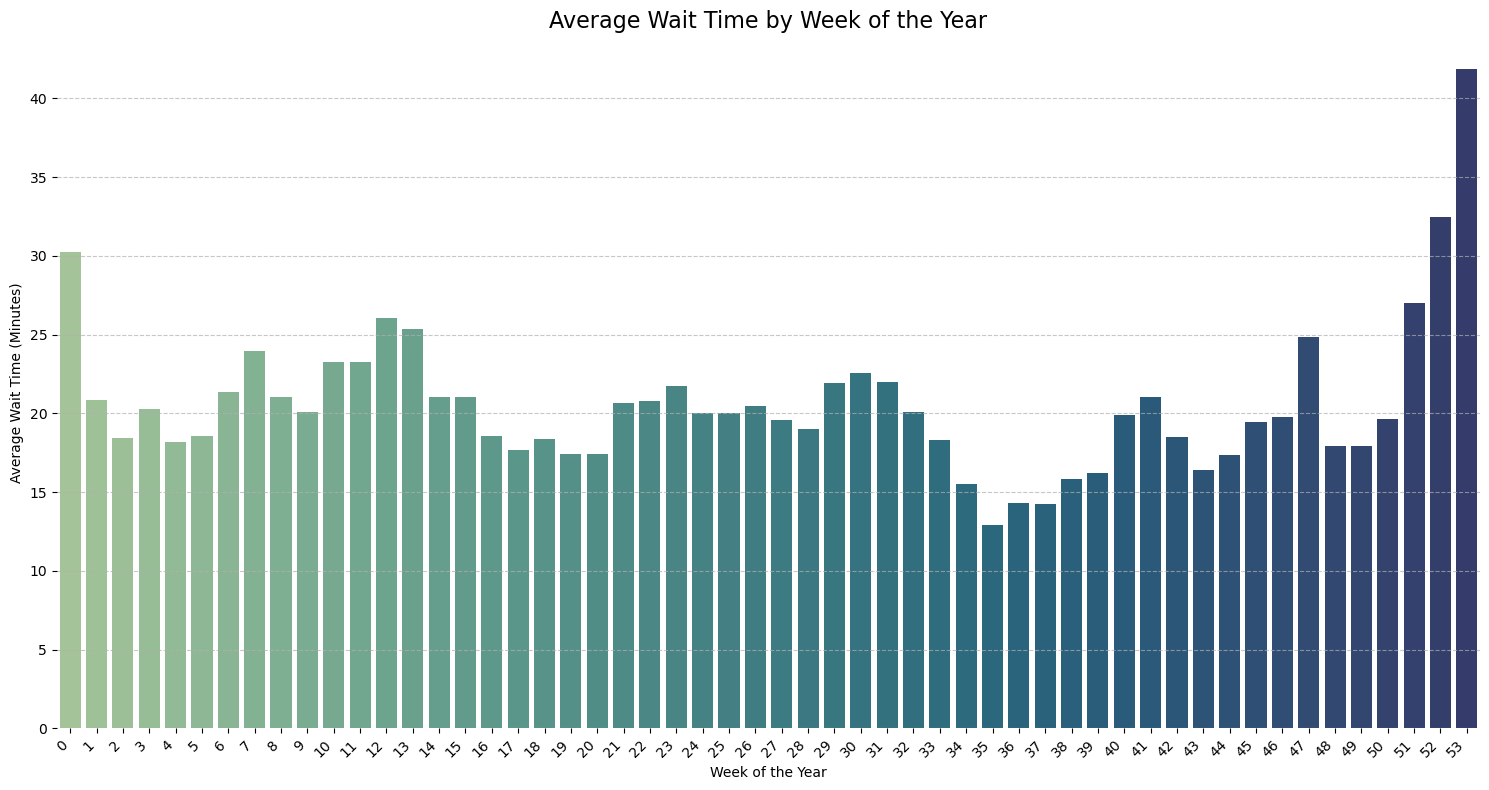

In [34]:
df_main_week = df_int_time_p_main.copy()
week_avg = df_main_week.groupby("WEEKOFYEAR")["SPOSTMIN"].mean().reset_index().copy()
# Enhanced Plotting with Nice Colors
plt.figure(figsize=(15, 8))
palette = sns.color_palette("crest", len(week_avg)) #Use viridis palette
ax = sns.barplot(x="WEEKOFYEAR", y="SPOSTMIN", data=week_avg, palette=palette)

ax.set_title("Average Wait Time by Week of the Year", fontsize=16)
ax.set(xlabel="Week of the Year", ylabel="Average Wait Time (Minutes)")

plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)

ax.yaxis.grid(True, linestyle='--', alpha=0.7)

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

In [49]:
df_peeps = df_itp_entities[['name','date', 'minute', 'SPOSTMIN', 'duration','scope_and_scale_code','climate_controlled']].copy()
display(df_peeps)

,name,date,minute,SPOSTMIN,duration,scope_and_scale_code,climate_controlled
0,Astro Orbiter,2015-01-01,0,0.0,1.5,minor_attraction,False
1,Astro Orbiter,2015-01-01,30,0.0,1.5,minor_attraction,False
2,Astro Orbiter,2015-01-01,60,0.0,1.5,minor_attraction,False
3,Astro Orbiter,2015-01-01,90,0.0,1.5,minor_attraction,False
4,Astro Orbiter,2015-01-01,120,0.0,1.5,minor_attraction,False
...,...,...,...,...,...,...,...
2586315,The Many Adventures of Winnie the Pooh,2021-12-28,1500,5.0,4.0,minor_attraction,True
2586316,The Many Adventures of Winnie the Pooh,2021-12-28,1530,5.0,4.0,minor_attraction,True
2586317,The Many Adventures of Winnie the Pooh,2021-12-28,1560,5.0,4.0,minor_attraction,True
2586318,The Many Adventures of Winnie the Pooh,2021-12-28,1590,5.0,4.0,minor_attraction,True


In [50]:
chosen_busy_days = ['2018-05-12', '2019-02-26']
chosen_slow_days = ['2017-10-05', '2018-05-20']
chosen_days = chosen_busy_days + chosen_slow_days

df_peeps = df_itp_entities[['date','duration', 'scope_and_scale_code', 'climate_controlled']].copy()

# Filter dataframes by chosen_days
df_int_time_p_weather_filtered = df_int_time_p_weather[df_int_time_p_weather['date'].isin(chosen_days)].copy()
df_peeps_filtered = df_peeps[df_peeps['date'].isin(chosen_days)].copy()

# Merge the filtered dataframes on 'date'
merged_df = pd.merge(df_int_time_p_weather_filtered, df_peeps_filtered, on='date')


# Display the resulting dataframe
display(merged_df)

C:\Users\masha\AppData\Local\Temp\ipykernel_2668\885727184.py:8: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df_int_time_p_weather_filtered = df_int_time_p_weather[df_int_time_p_weather['date'].isin(chosen_days)].copy()
C:\Users\masha\AppData\Local\Temp\ipykernel_2668\885727184.py:9: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df_peeps_filtered = df_peeps[df_peeps['date'].isin(chosen_days)].copy()


,attraction,date,minute,SPOSTMIN,DAYOFWEEK,DAYOFYEAR,WEEKOFYEAR,MONTHOFYEAR,YEAR,WDWMAXTEMP,WDWMINTEMP,WDWMEANTEMP,WEATHER_WDWHIGH,WEATHER_WDWLOW,WEATHER_WDWPRECIP,duration,scope_and_scale_code,climate_controlled
0,astro_orbiter,2017-10-05,0,0.0,5,277,40,10,2017,25.455556,22.683333,24.066667,30.333333,21.888889,0.16,1.5,minor_attraction,False
1,astro_orbiter,2017-10-05,0,0.0,5,277,40,10,2017,25.455556,22.683333,24.066667,30.333333,21.888889,0.16,1.5,minor_attraction,False
2,astro_orbiter,2017-10-05,0,0.0,5,277,40,10,2017,25.455556,22.683333,24.066667,30.333333,21.888889,0.16,1.5,minor_attraction,False
3,astro_orbiter,2017-10-05,0,0.0,5,277,40,10,2017,25.455556,22.683333,24.066667,30.333333,21.888889,0.16,1.5,minor_attraction,False
4,astro_orbiter,2017-10-05,0,0.0,5,277,40,10,2017,25.455556,22.683333,24.066667,30.333333,21.888889,0.16,1.5,minor_attraction,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7592745,winnie_the_pooh,2019-02-26,1620,15.0,3,56,8,2,2019,23.000000,15.366667,19.183333,23.611111,12.777778,0.16,4.0,minor_attraction,True
7592746,winnie_the_pooh,2019-02-26,1620,15.0,3,56,8,2,2019,23.000000,15.366667,19.183333,23.611111,12.777778,0.16,4.0,minor_attraction,True
7592747,winnie_the_pooh,2019-02-26,1620,15.0,3,56,8,2,2019,23.000000,15.366667,19.183333,23.611111,12.777778,0.16,4.0,minor_attraction,True
7592748,winnie_the_pooh,2019-02-26,1620,15.0,3,56,8,2,2019,23.000000,15.366667,19.183333,23.611111,12.777778,0.16,4.0,minor_attraction,True


In [51]:
filtered_df = merged_df[merged_df['date'].isin(chosen_days)]

display(filtered_df)

# Find unique attractions with climate_controlled == True
climate_control_true_attractions = filtered_df[filtered_df['climate_controlled'] == True]['attraction'].unique()

# Find unique attractions with climate_controlled == False
climate_control_false_attractions = filtered_df[filtered_df['climate_controlled'] == False]['attraction'].unique()

# Print the unique attractions
print("Attractions with Climate Control:")
for attraction in climate_control_true_attractions:
    print(f"- {attraction}")

print("\nAttractions without Climate Control:")
for attraction in climate_control_false_attractions:
    print(f"- {attraction}")

C:\Users\masha\AppData\Local\Temp\ipykernel_2668\820058789.py:1: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  filtered_df = merged_df[merged_df['date'].isin(chosen_days)]


,attraction,date,minute,SPOSTMIN,DAYOFWEEK,DAYOFYEAR,WEEKOFYEAR,MONTHOFYEAR,YEAR,WDWMAXTEMP,WDWMINTEMP,WDWMEANTEMP,WEATHER_WDWHIGH,WEATHER_WDWLOW,WEATHER_WDWPRECIP,duration,scope_and_scale_code,climate_controlled
0,astro_orbiter,2017-10-05,0,0.0,5,277,40,10,2017,25.455556,22.683333,24.066667,30.333333,21.888889,0.16,1.5,minor_attraction,False
1,astro_orbiter,2017-10-05,0,0.0,5,277,40,10,2017,25.455556,22.683333,24.066667,30.333333,21.888889,0.16,1.5,minor_attraction,False
2,astro_orbiter,2017-10-05,0,0.0,5,277,40,10,2017,25.455556,22.683333,24.066667,30.333333,21.888889,0.16,1.5,minor_attraction,False
3,astro_orbiter,2017-10-05,0,0.0,5,277,40,10,2017,25.455556,22.683333,24.066667,30.333333,21.888889,0.16,1.5,minor_attraction,False
4,astro_orbiter,2017-10-05,0,0.0,5,277,40,10,2017,25.455556,22.683333,24.066667,30.333333,21.888889,0.16,1.5,minor_attraction,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7592745,winnie_the_pooh,2019-02-26,1620,15.0,3,56,8,2,2019,23.000000,15.366667,19.183333,23.611111,12.777778,0.16,4.0,minor_attraction,True
7592746,winnie_the_pooh,2019-02-26,1620,15.0,3,56,8,2,2019,23.000000,15.366667,19.183333,23.611111,12.777778,0.16,4.0,minor_attraction,True
7592747,winnie_the_pooh,2019-02-26,1620,15.0,3,56,8,2,2019,23.000000,15.366667,19.183333,23.611111,12.777778,0.16,4.0,minor_attraction,True
7592748,winnie_the_pooh,2019-02-26,1620,15.0,3,56,8,2,2019,23.000000,15.366667,19.183333,23.611111,12.777778,0.16,4.0,minor_attraction,True


Attractions with Climate Control:
- astro_orbiter
- barnstormer
- big_thunder_mtn
- buzz_lightyear
- dinosaur
- dumbo
- expedition_everest
- flight_of_passage
- haunted_mansion
- it_s_a_small_world
- jungle_cruise
- kilimanjaro_safaris
- laugh_floor
- mad_tea_party
- magic_carpets
- navi_river
- peter_pan_s_flight
- philharmagic
- pirates_of_caribbean
- princess_hall__cinderella_elena
- princess_hall__rapunzel_tiana
- regal_carrousel
- rock_n_rollercoaster
- soarin
- space_mountain
- spaceship_earth
- tom_land_speedway
- town_sq_mickey
- toy_story_mania
- under_the_sea
- winnie_the_pooh
- splash_mountain
- alien_saucers
- peoplemover
- slinky_dog

Attractions without Climate Control:
- astro_orbiter
- barnstormer
- big_thunder_mtn
- buzz_lightyear
- dinosaur
- dumbo
- expedition_everest
- flight_of_passage
- haunted_mansion
- it_s_a_small_world
- jungle_cruise
- kilimanjaro_safaris
- laugh_floor
- mad_tea_party
- magic_carpets
- navi_river
- peter_pan_s_flight
- philharmagic
- pirates_

C:\Users\masha\AppData\Local\Temp\ipykernel_2668\1799601734.py:1: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  filtered_df = merged_df[merged_df['date'].isin(chosen_days)]


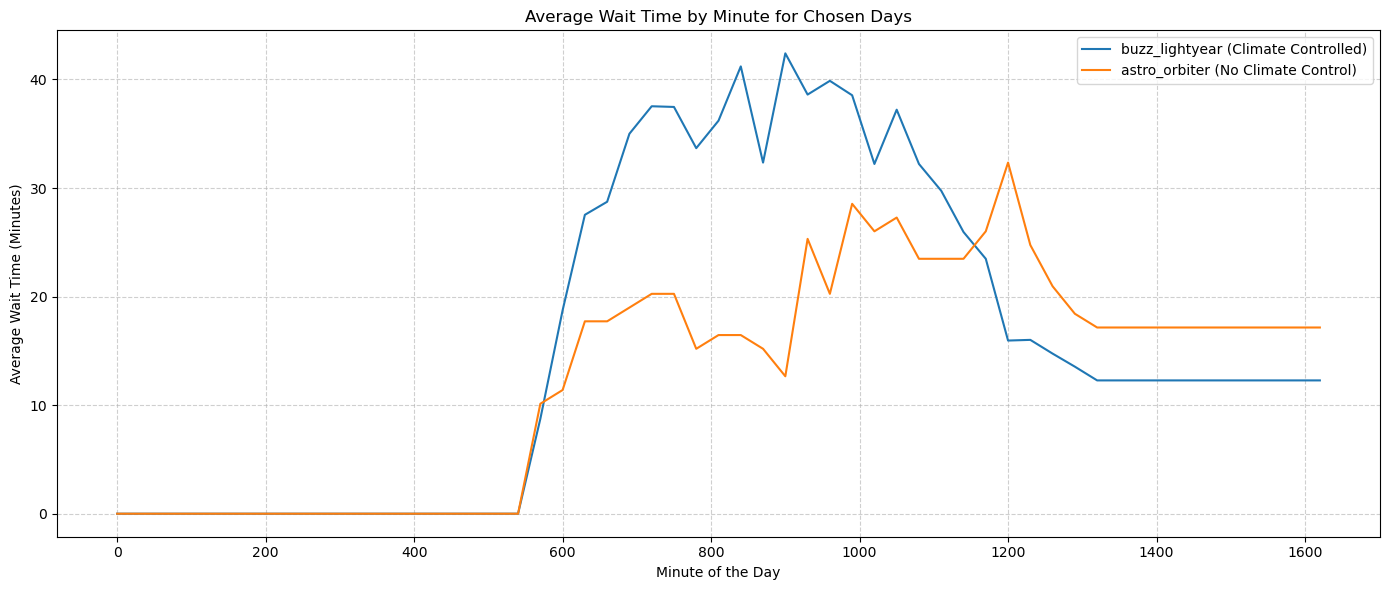

In [52]:
filtered_df = merged_df[merged_df['date'].isin(chosen_days)]

# Filter data for buzz_lightyear (climate control)
buzz_lightyear_df = filtered_df[filtered_df['attraction'] == 'buzz_lightyear']

# Filter data for astro_orbiter (no climate control)
astro_orbiter_df = filtered_df[filtered_df['attraction'] == 'astro_orbiter']

# Group by minute and calculate average wait time for each attraction
avg_wait_buzz = buzz_lightyear_df.groupby('minute')['SPOSTMIN'].mean()
avg_wait_astro = astro_orbiter_df.groupby('minute')['SPOSTMIN'].mean()

# Plot the lines
plt.figure(figsize=(14, 6))
plt.plot(avg_wait_buzz.index, avg_wait_buzz.values, label='buzz_lightyear (Climate Controlled)')
plt.plot(avg_wait_astro.index, avg_wait_astro.values, label='astro_orbiter (No Climate Control)')

plt.title('Average Wait Time by Minute for Chosen Days')
plt.xlabel('Minute of the Day')
plt.ylabel('Average Wait Time (Minutes)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

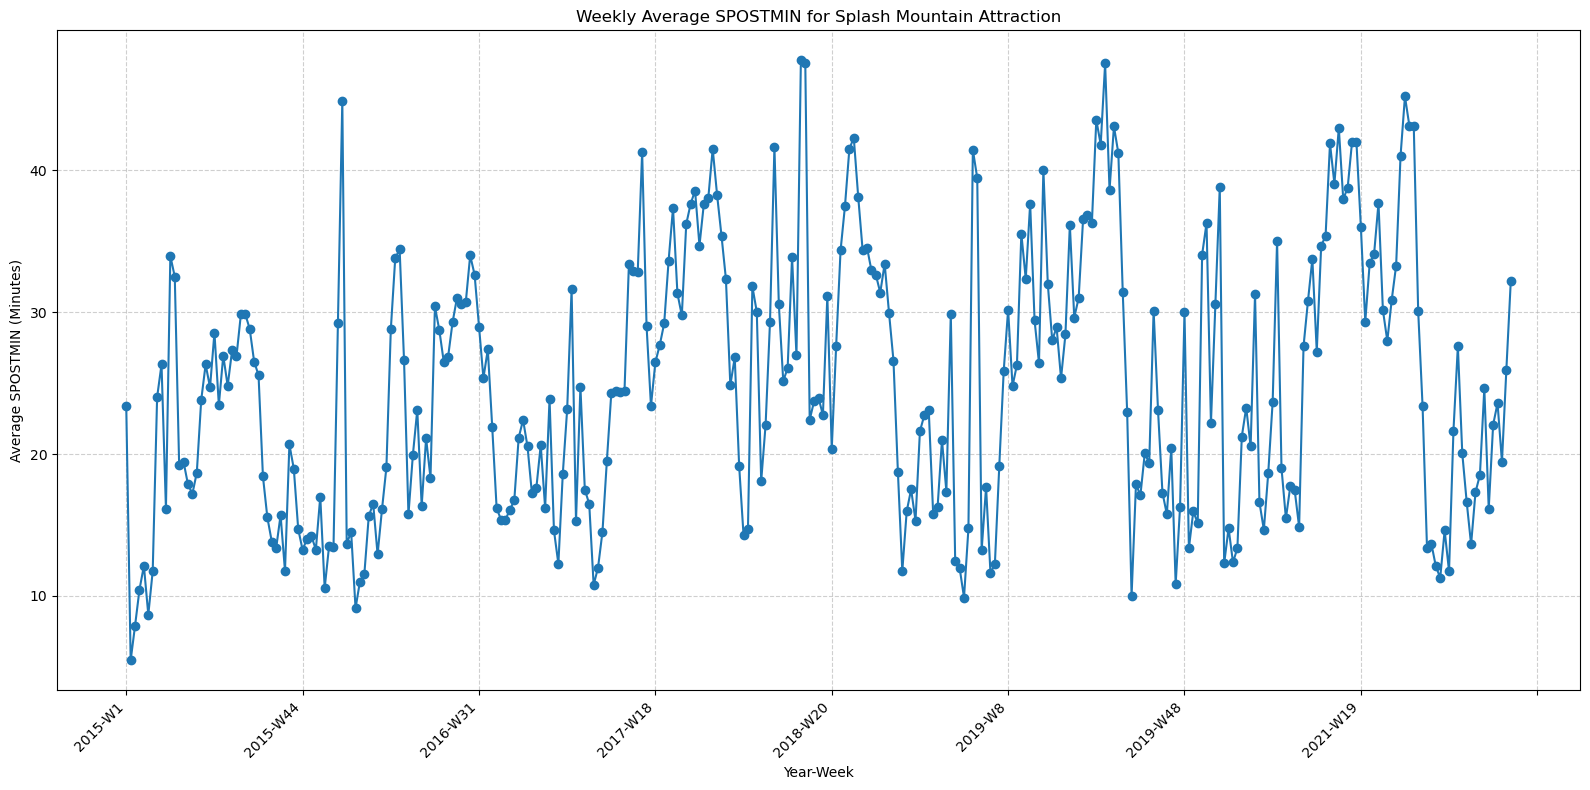

In [63]:
import matplotlib.ticker as ticker

# Assuming your DataFrame is named 'df_int_time_p'

# Filter data for the 'dinosaur' attraction
dinosaur_df = df_int_time_p[df_int_time_p['attraction'] == 'splash_mountain'].copy()

# Convert 'date' to datetime objects
dinosaur_df['date'] = pd.to_datetime(dinosaur_df['date'])

# Extract year and week number
dinosaur_df['year'] = dinosaur_df['date'].dt.year
dinosaur_df['week'] = dinosaur_df['date'].dt.isocalendar().week

# Group by year and week, then calculate the average SPOSTMIN
weekly_avg = dinosaur_df.groupby(['year', 'week'])['SPOSTMIN'].mean().reset_index()

# Create a combined year-week label for the x-axis
weekly_avg['year_week'] = weekly_avg['year'].astype(str) + '-W' + weekly_avg['week'].astype(str)

# Plot the weekly average SPOSTMIN values
plt.figure(figsize=(16, 8))
plt.plot(weekly_avg['year_week'], weekly_avg['SPOSTMIN'], marker='o', linestyle='-')

plt.title('Weekly Average SPOSTMIN for Splash Mountain Attraction')
plt.xlabel('Year-Week')
plt.ylabel('Average SPOSTMIN (Minutes)')
plt.grid(True, linestyle='--', alpha=0.6)

# Clean the x-axis
ax = plt.gca() #get current axis
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True)) #make x axis integers
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()